# Chronos Test

In this example, we will test Chronos on canonical geoscientific data sets chosen to be representative of geoscience/geophysics:
1. earthquake catalogs from SoCal
2. earthquake ground motion waveforms
3. near surface properties (seismic velocities, temperature, soil moisture)
4. ice velocity from greenland
5. GPS positions along a plate boundary that captures seasons and tectonic loading

The data has been prepared as CSV files with times series.
The forescasts are added to the CSV files under key attributes "Chronos-zero-shot".

Limitations by [Chronos](https://arxiv.org/pdf/2403.07815). Chronos uses large language models at its core for forecasting time series. The time series is "tokenized" to convert from an array of floats into contect tokens.


By Marine Denolle (mdenolle@uw.edu)


In [11]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

10722

In [1]:
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import pandas as pd
import numpy as np


# Set the font style and size
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.serif': ['DejaVu Sans'],
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})


In [2]:
n_timeseries = 10

In [3]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

Some functions

In [7]:
def reshape_time_series(df, name_of_target="count" ,n_timeseries=20, duration_years=2):
    """
    Generate a list of time series from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing a 'datetime' column.
    n_timeseries (int): Number of time series to generate.
    duration_years (int): Duration of each time series in years.
    resample_period (str): Resampling period (e.g., 'D' for daily).

    Returns:
    list: A list of DataFrames, each containing a time series.
    pd.DataFrame: A wide-format DataFrame containing the time series.
    """
    df_list = [pd.DataFrame() for _ in range(n_timeseries)]
    kk = 0
    while kk < n_timeseries:
        start_date = df["datetime"].sample().values[0]
        start_date = pd.to_datetime(start_date)
        # Create a time series for the specified duration
        end_date = start_date + pd.DateOffset(years=duration_years)
        if end_date > df["datetime"].max():
            continue    # Skip if the end date exceeds the maximum date in the catalog
        # Create a time series from the catalog and select only the date time and target columns
        time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)][["datetime", name_of_target]]
        time_series = time_series.set_index("datetime")
        # time_series = time_series.resample(resample_period).mean().interpolate() # resample and interpolate
        time_series = time_series.ffill()#(method="ffill") # forward fill
        time_series = time_series.bfill()#(method="bfill") # backward fill
        time_series = time_series.reset_index()# reset index to keep datetime as a column
        # remove the "datetime" column to the time_series
        
        df_list[kk] = time_series
        kk += 1 
    df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
    for ik in range(n_timeseries):
        df_list_count[ik] = df_list[ik][name_of_target]
        df_list_count[ik] = df_list_count[ik].rename(f"target_{ik}")
    df_wide = pd.concat(df_list_count, axis=1)

    # find the sampling rate dt as the difference between the first two dates
    dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
    # convert dt to days
    dt = dt / (24 * 3600)
    print("sampling rate {:.2f} days".format(dt))

    # create a time array that is the index of the time series and convert the dae
    df_wide["time_index"] = np.arange(len(df_wide)) #* pd.Timedelta(days=dt)
    # move the last column to the first position
    cols = df_wide.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_wide = df_wide[cols]

    # rename columns to target_ID except for the first column that is a datetime
    df_wide.columns = [f"target_{i}" if i != 0 else "time_index" for i in range(len(df_wide.columns))]
    df_wide = df_wide.dropna() 
    
    return df_list, df_wide

# Example usage:
# df_list,df_wide = reshape_time_series(df, n_timeseries=20, duration_years=2, resample_period='D')

In [128]:
def predict_chronos(df, predict_length=64, n_timeseries=20):
    """
    Make predictions for the given time series data.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
    forecast_mean (np.array): The mean forecasted values for the time series.
    lower_bound (np.array): The 5% lower bound of the forecasted values.
    upper_bound (np.array): The 95% upper bound of the forecasted values.
    mean_mae (float): The mean absolute error of the forecasted values.
    no_var_mae (float): The mean absolute error assuming no change in the time series.


    """
    # Ensure df['Date'] is in datetime format
    # df['datetime'] = pd.to_datetime(df['datetime'])

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    # Calculate the split index for training
    split_index = int(len(df) - predict_length)

    # Split the data into training and evaluation sets for all selected columns
    train_data = df[columns_to_forecast].iloc[:split_index]
    eval_data = df[columns_to_forecast].iloc[split_index:]

    # Convert the training data to a higher-dimensional tensor
    train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T
    # Perform the forecasting using the training data
    forecast = pipeline.predict(
        context=train_tensor,
        prediction_length=len(eval_data),  # Predict the same length as the evaluation set
        num_samples=50,
    )

    # Take the mean across the samples (axis=1) for each time series
    forecast_mean = forecast.mean(dim=1).squeeze().numpy()
    # lower_bound = forecast.quantile(0.05, dim=1).squeeze().numpy()
    # upper_bound = forecast.quantile(0.95, dim=1).squeeze().numpy()


    mae=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae.append (np.mean(np.abs(forecast_mean[i]- eval_data[column_name].values)))
        
        # Print the MAE
        print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

    mean_mae = np.array(mae).mean()
    print(f'Mean of forecast MAEs = {mean_mae}')

    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i] - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
        # Print the MASE
        print(f'Mean Absolute Scaled Error (MASE) for {column_name}: {mase[-1]}')

    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MAEs = {mean_mase}')


    # Baseline model: Assume no change in the time series
    mae_nochangemodel=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
        
        # Print the MAE
        # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

    no_var_mae = np.array(mae_nochangemodel).mean()
    print(f'Mean of d/dt=0 MAEs = {no_var_mae}')

    return forecast,mean_mae, mean_mase, no_var_mae, split_index

In [216]:
import matplotlib.dates as mdates
def plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="count",filename="geo-forecast.png"):
    """
    Plot the forecasted values along with the confidence intervals.

    Parameters:
    n_timeseries (int): Number of time series to plot.
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    split_index (int): The index at which the training data ends (or context data) and evaluation (or forecast) data begins.
    forecast (np.array): The forecasted values for the time series.
    filename (str): The filename to save the plot.


    Returns:
    None


    """
    
    # Determine the number of rows and columns for the subplots
    n_timeseries = min(n_timeseries, 12)  # Cap the number of time series to 12
    nrows = (n_timeseries - 1) // 3 + 1
    ncols = min(n_timeseries, 3)

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    forecast_mean = forecast.mean(dim=1).squeeze()
    lower_bound = np.percentile(forecast, 5, axis=0)
    upper_bound = np.percentile(forecast, 95, axis=0)

    # Layout the subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 16), sharex=True)
    # Flatten the 2D array of axes for easy indexing
    axes = axes.flatten()


    # Split the data into training and evaluation sets for all selected columns
    # train_data = df_wide[columns_to_forecast].iloc[:split_index]
    eval_data = df_wide[columns_to_forecast].iloc[split_index:]


    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i].numpy()  - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MASEs = {mean_mase}')

    # Iterate over the first n_timeseries and plot
    for i, column_name in enumerate(columns_to_forecast[0:n_timeseries]):
        # Plot the original data
        axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
        
        # Calculate the 5th and 95th percentiles for the confidence interval
        lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
        upper_bound = np.percentile(forecast[i, :, :], 95, axis=0)
        
        # Plot the forecast
        axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean[i], label='Forecast')
        
        # Plot the confidence intervals
        axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                            color='r', alpha=0.2, label='95% CI')


        # set the x-axis labels as the number of days
        # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
        axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

        # Plot the evaluation data for reference
        # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

        # Format the subplot
        axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
        axes[i].set_ylabel(field)
        axes[i].set_xlabel('Days')
        if i==0: axes[i].legend()

        # Apply x-tick rotation
        # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)
        # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        # convert the x-labels to days every month
        # axes[i].xaxis.set_major_locator(plt.MaxNLocator(6))

    # Remove empty subplots if n_timeseries < 8
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(filename)
    # also save a SVG 
    plt.savefig(filename.replace('.png','.svg'))
    plt.show()


    # add a column to df_wide with the predictions for each target_{i} labels at the rows of the evaluation data
    for i, column_name in enumerate(columns_to_forecast):
        df_wide.loc[df_wide.index[split_index:], f'forecast_{i}'] = forecast_mean[i].numpy()

    # store the new df_wide with the precition into a new CSV files that takes the filename of the original file
    df_wide.to_csv(filename.replace('.png','.csv'), index=False)

    return

In [191]:
# Quick plot
def quick_plot(df_wide,n_timeseries,field="count",dt=1):
    """
    Quick plot of the time series data.

    Parameters:
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    n_timeseries (int): Number of time series to plot.
    field (str): The field to plot.


    Returns:
    None
    """
    # Determine the number of rows and columns for the subplots
    n_timeseries2 = min(n_timeseries, 6)  # Cap the number of time series to 12
    nrows = (n_timeseries2 - 1) // 3 + 1
    ncols = min(n_timeseries2, 3)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 8))  # define the figure and subplots
    axes = axes.ravel()
    for i in range(n_timeseries2):
        # create a time axis that multiplies time_data by dt
        # Calculate the time index as the difference from the first datetime
        # df_wide['time_index'] = (df_wide['time_index'] - df_wide['time_index'].iloc[0]).dt.total_seconds() / (24 * 3600)

        # Convert the time_index to a float array
        time_index_days_float = df_wide['time_index'].values


      
        ax = axes[i]
        ax.plot(time_index_days_float, df_wide[f"target_{i+1}"], label=f"{field}_{i+1}")
        ax.set_title(f"{field} {i}")
        ax.set_xlabel("Days")
        ax.set_ylabel(field)
        plt.tight_layout()
        ax.grid()

    plt.show()

## Earthquake Data


In [124]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

datetime  count
0  2008-01-01    120
1  2008-01-02     89
2  2008-01-03    146
3  2008-01-04    166
4  2008-01-05     94

In [125]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print(dt)

1.0


## Reshape for Prediction

In [126]:
# randomly cut the long time series into n_timeseries, stored in data frames.
df_list,df_wide = reshape_time_series(df, name_of_target="count", n_timeseries=n_timeseries, duration_years=2)

sampling rate 1.00 days
   time_index  target_1  target_2  target_3  target_4  target_5  target_6  \
0           0       205       217     135.0     232.0     241.0     179.0   
1           1       162       178     197.0     227.0     152.0     141.0   
2           2       254       188     198.0     358.0     253.0     165.0   
3           3       195       205     225.0     452.0     439.0     131.0   
4           4       195       162     185.0     703.0     425.0     153.0   

   target_7  target_8  target_9  target_10  
0       202     149.0     215.0      336.0  
1       164     148.0     193.0      225.0  
2       180     149.0     188.0      188.0  
3       146     209.0     216.0      264.0  
4       153     136.0     420.0      183.0  


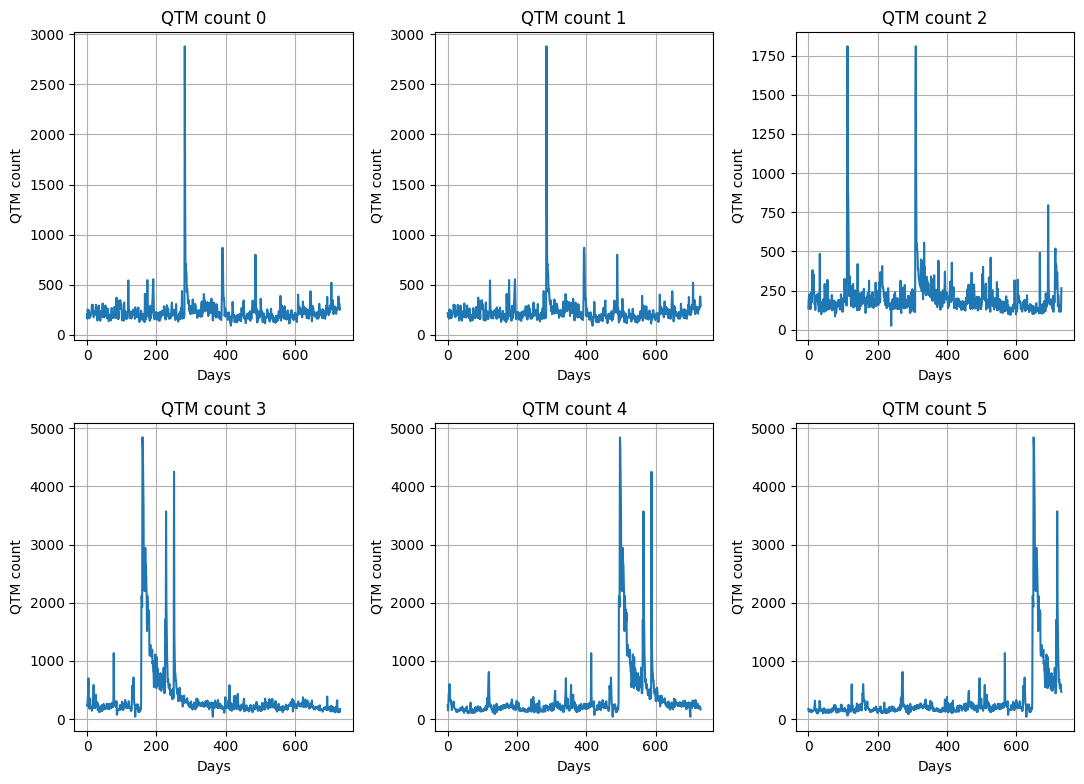

In [137]:
quick_plot(df_wide,n_timeseries,field="QTM count",dt=1)

### Predict with Chronos & Plot

Mean Absolute Error (MAE) for target_1: 63.131614685058594
Mean Absolute Error (MAE) for target_2: 61.90980911254883
Mean Absolute Error (MAE) for target_3: 82.96797037124634
Mean Absolute Error (MAE) for target_4: 52.48136496543884
Mean Absolute Error (MAE) for target_5: 36.96929693222046
Mean Absolute Error (MAE) for target_6: 1123.17506980896
Mean Absolute Error (MAE) for target_7: 57.87794351577759
Mean Absolute Error (MAE) for target_8: 41.71311712265015
Mean Absolute Error (MAE) for target_9: 30.928062438964844
Mean Absolute Error (MAE) for target_10: 23.77564573287964
Mean of forecast MAEs = 157.49298946857454
Mean Absolute Scaled Error (MASE) for target_1: 1.3244394689173131
Mean Absolute Scaled Error (MASE) for target_2: 1.3027114141919092
Mean Absolute Scaled Error (MASE) for target_3: 1.1243239693242673
Mean Absolute Scaled Error (MASE) for target_4: 1.3353497547748978
Mean Absolute Scaled Error (MASE) for target_5: 0.8822218586098064
Mean Absolute Scaled Error (MASE) for ta

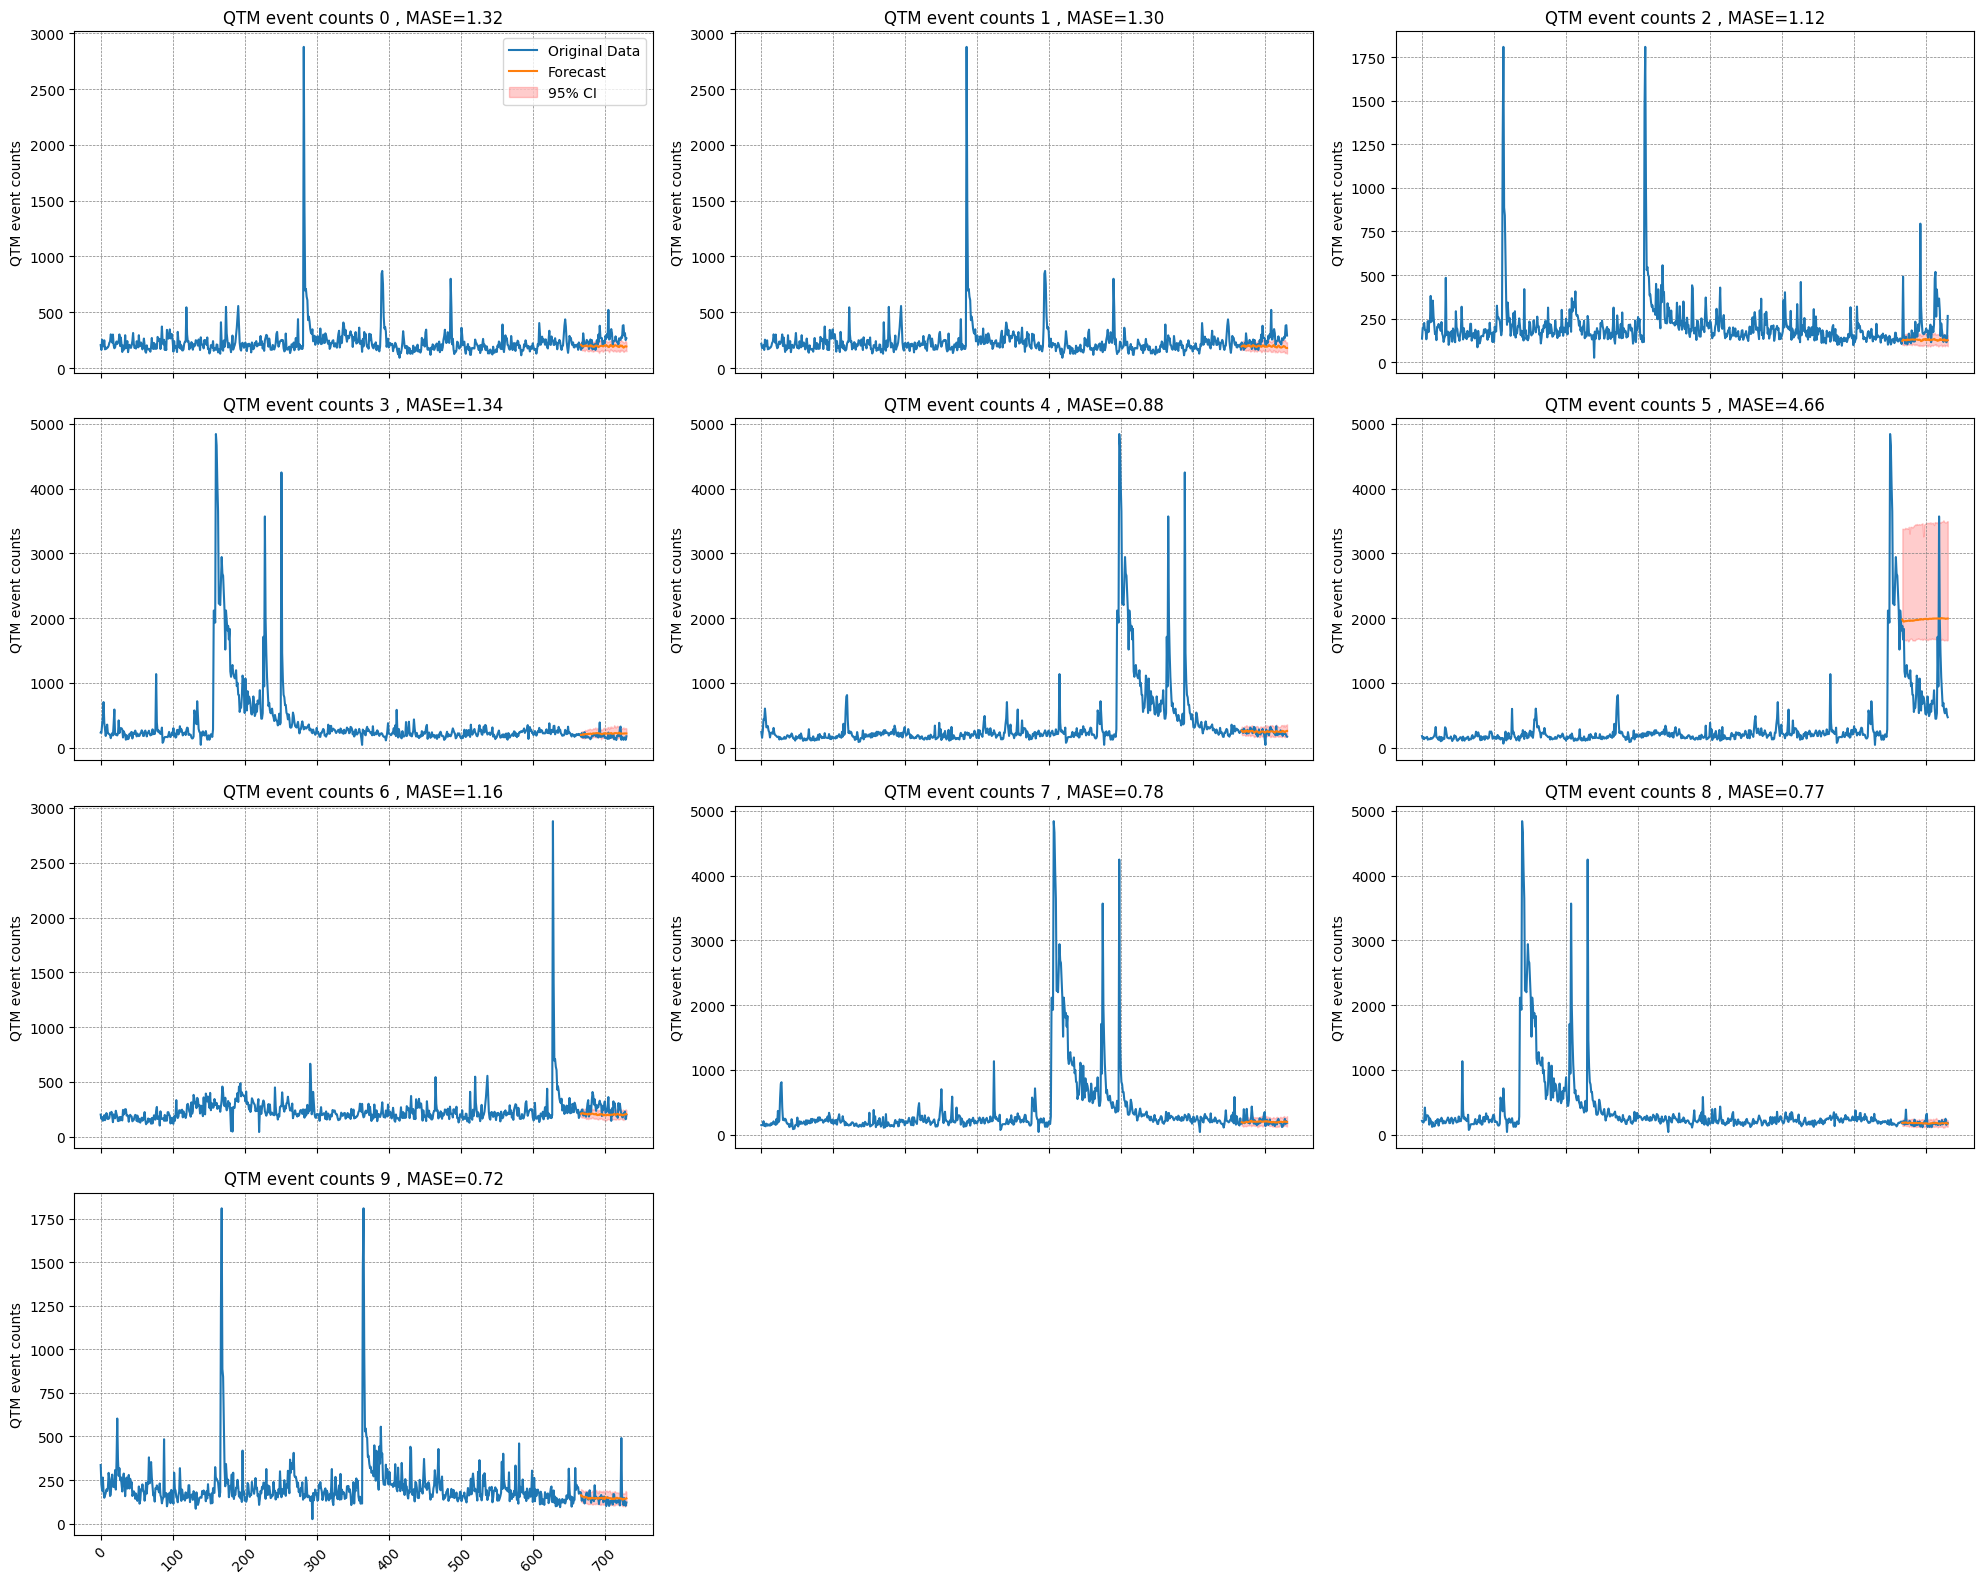

In [145]:
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="QTM event counts",filename="./plots/quake_qtm_forecast.png")
# save a vectorized plot

## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [193]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [194]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["Date"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print("sampling rate {} days".format(dt))

sampling rate 8.0 days


### Reshape for prediction

In [195]:
df_wide = df
df_wide.dropna()

Date  Pixel Value (x=2500, y=8200)  Pixel Value (x=2500, y=8201)  \
0    2015-01-01                     2690.5570                     2682.3616   
1    2015-01-13                     2714.7678                     2694.3774   
2    2015-01-25                     2712.4210                     2724.5880   
4    2015-02-18                     2641.4170                     2613.6772   
5    2015-03-02                     2695.7231                     2654.4783   
..          ...                           ...                           ...   
437  2024-02-25                     2355.7673                     2317.1812   
438  2024-03-08                     2356.8071                     2318.0103   
439  2024-03-20                     2369.9165                     2318.2954   
440  2024-04-01                     2304.3186                     2255.6506   
441  2024-04-13                     2300.0273                     2244.5710   

     Pixel Value (x=2500, y=8202)  Pixel Value (x=2500, y=8203)  \
0                       2658.6174                     2606.9355   
1                       2657.5322                     2604.6094   
2                       2735.8308                     2645.3513   
4                       2577.1538                     2528.2330   
5                       2596.1223                     2527.4956   
..                            ...                           ...   
437                     2267.6526                     2218.5762   
438                     2271.4500                     2208.3280   
439                     2239.7700                     2166.4363   
440                     2209.5908                     2154.6484   
441                     2165.4233                     2103.4187   

     Pixel Value (x=2500, y=8204)  Pixel Value (x=2500, y=8205)  \
0                       2530.3400                     2432.4604   
1                       2541.0916                     2492.7390   
2                       2518.3074                     2460.4731   
4                       2444.6372                     2356.7375   
5                       2450.6010                     2383.8125   
..                            ...                           ...   
437                     2174.4893                     2119.7183   
438                     2131.2380                     2038.9028   
439                     2106.1460                     2046.7198   
440                     2079.5513                     1998.6061   
441                     2059.3809                     1990.8022   

     Pixel Value (x=2500, y=8206)  Pixel Value (x=2500, y=8207)  \
0                       2337.5603                     2238.3130   
1                       2451.3862                     2415.7693   
2                       2262.7056                     2141.2844   
4                       2280.1716                     2216.3354   
5                       2317.7700                     2231.7078   
..                            ...                           ...   
437                     2036.1709                     1886.2402   
438                     1941.8640                     1839.1848   
439                     1997.2346                     1934.0216   
440                     1931.5712                     1849.2580   
441                     1887.8052                     1750.1135   

     Pixel Value (x=2500, y=8208)  ...  Pixel Value (x=2509, y=8201)  \
0                       2131.6187  ...                     1860.1473   
1                       2235.5337  ...                     1866.2997   
2                       2034.8848  ...                     1807.4071   
4                       2187.7751  ...                     1803.6461   
5                       2069.8728  ...                     1768.4241   
..                            ...  ...                           ...   
437                     1742.2327  ...                     1555.8588   
438                     1730.7375  ...                     1584.8710   

In [196]:
# remove the first column and place the last at first position
df_wide = df_wide.drop(columns=["Date"])
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]


In [197]:
# now rename all Pixel columns to indexes except for the first one
df_wide.columns = ["time_index"] + ["target_"+str(i) for i in range(len(df_wide.columns)-1)]   

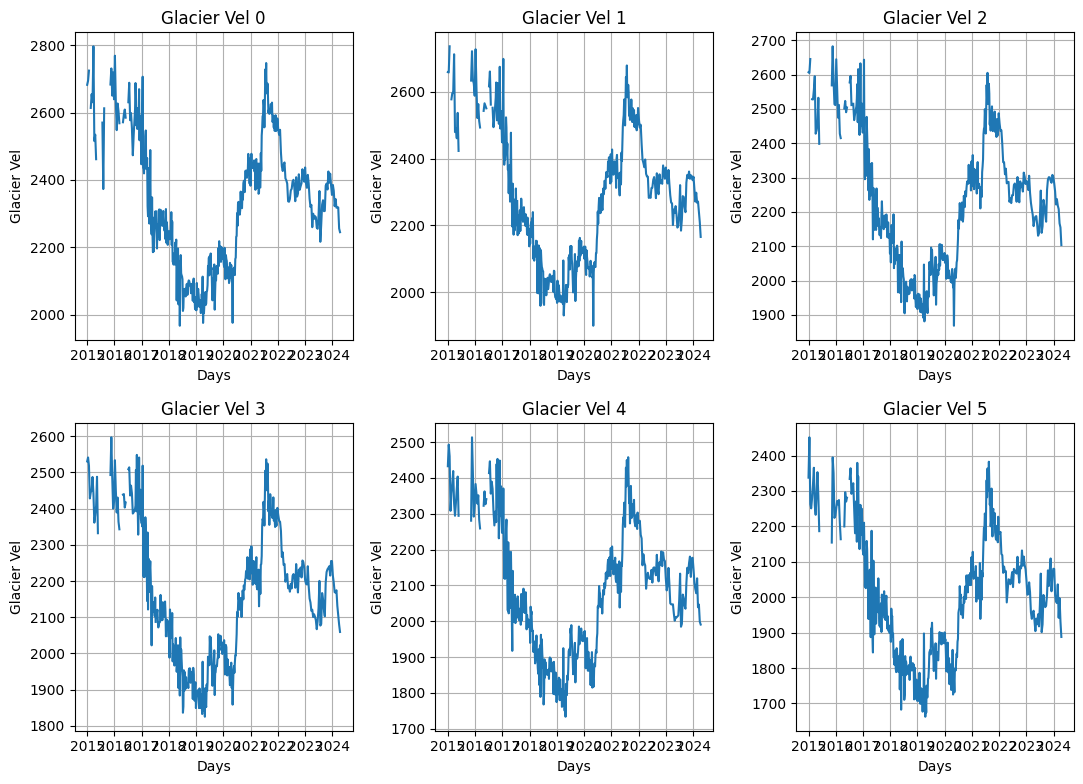

In [198]:
quick_plot(df_wide,n_timeseries,field="Glacier Vel",dt=8)

## now do a batch prediction

In [6]:
torch.cuda.empty_cache()
import gc
gc.collect()

22534

In [200]:
n_predict = 5
time_forecast = n_predict * dt 
print("Forecasting for {} days".format(time_forecast))

Forecasting for 40.0 days


## Predict & Plot forecasts with Chronos

Mean Absolute Error (MAE) for target_0: 35.07863609374999
Mean Absolute Error (MAE) for target_1: 56.53286054687506
Mean Absolute Error (MAE) for target_2: 61.985892421875086
Mean Absolute Error (MAE) for target_3: 70.82443703125
Mean Absolute Error (MAE) for target_4: 67.41780624999993
Mean Absolute Error (MAE) for target_5: 58.54797804687496
Mean Absolute Error (MAE) for target_6: 61.98314972656249
Mean Absolute Error (MAE) for target_7: 60.94443406250002
Mean Absolute Error (MAE) for target_8: 74.72263527343748
Mean Absolute Error (MAE) for target_9: 68.655218046875
Mean of forecast MAEs = 61.66930475
Mean Absolute Scaled Error (MASE) for target_0: 1.6696479749138593
Mean Absolute Scaled Error (MASE) for target_1: 3.0215883539710804
Mean Absolute Scaled Error (MASE) for target_2: 2.2576426275061734
Mean Absolute Scaled Error (MASE) for target_3: 2.460089426437709
Mean Absolute Scaled Error (MASE) for target_4: 2.3427588690312744
Mean Absolute Scaled Error (MASE) for target_5: 1.6201

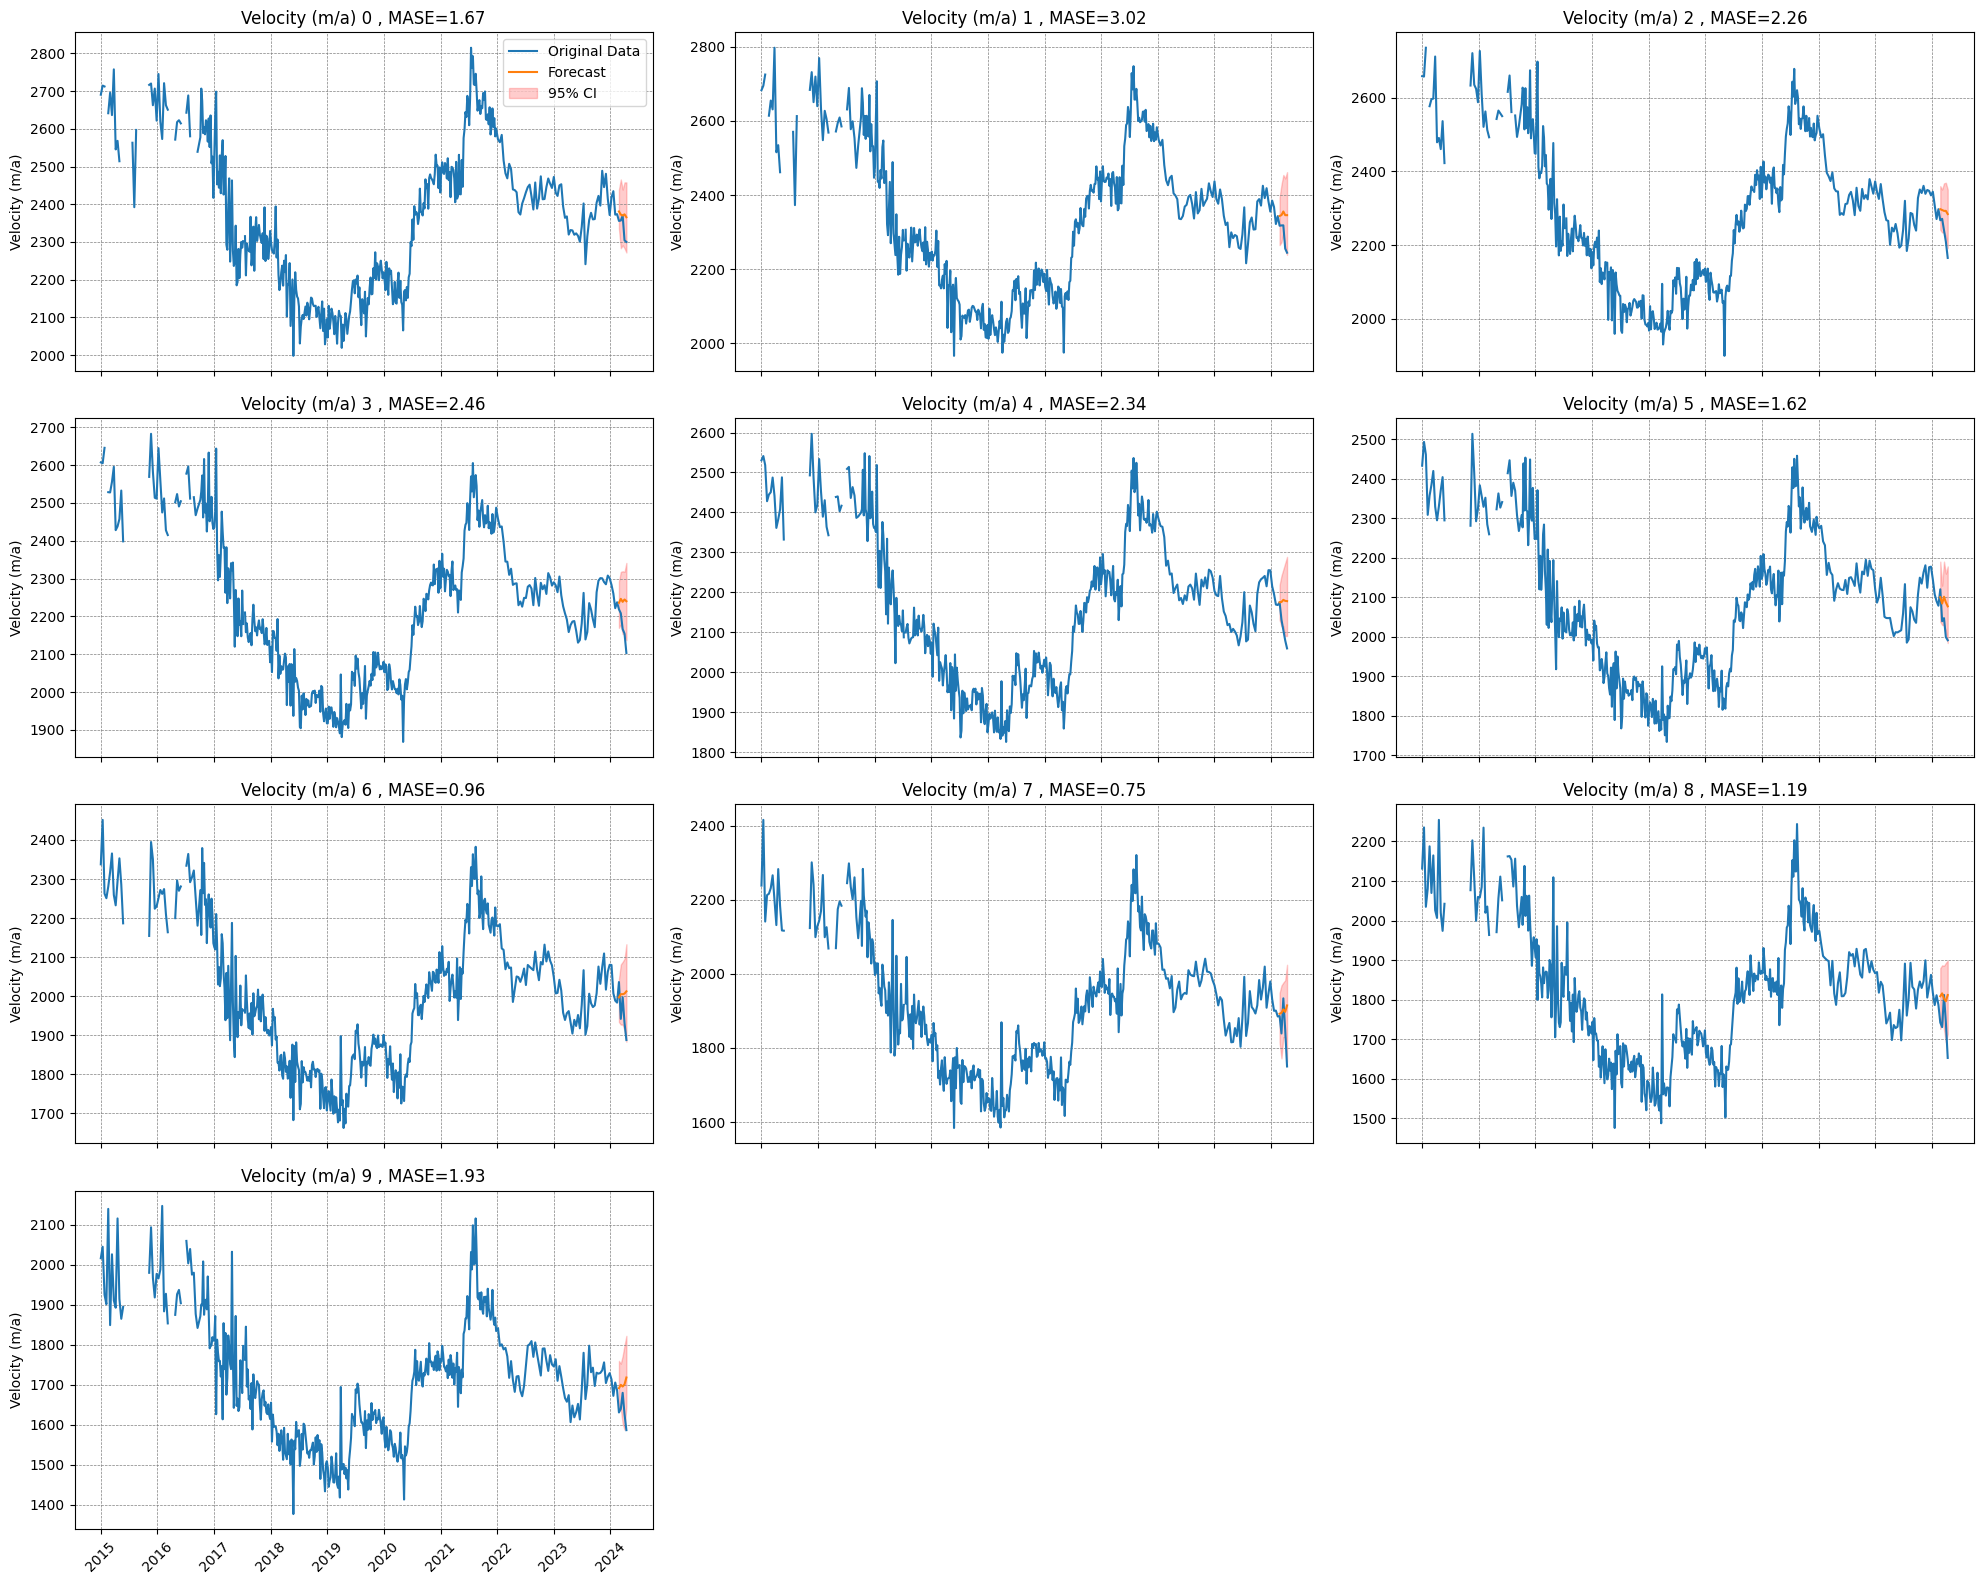

In [202]:
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,predict_length=n_predict,n_timeseries=n_timeseries)
# plot
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="Velocity (m/a)",filename="./plots/ice_jakobshavn_forecast.png")

## 3. Forecasting GPS velocities

In this case, we are going to test Chrono's performance on GPS time series. Vertical components tend to exhibit seasonal loading from precipitation, horizontal components tend to exhibit tectonic processes, especially at plate boundaries.

In [203]:
# read data from data_gps_P395_relateive_position.csv
fname = "../data/data_gps_P395_relative_position.csv"
df = pd.read_csv(fname)
# convert dacimal year column to floats
df["decimal year"] = df["decimal year"].astype(float)
df.head()

# the date format is in decimal years, convert it to datetime
# df["datetime"] = pd.to_datetime(df["decimal year"], format="%Y.%j")
# df.head()

decimal year  new delta e (m)  new delta n (m)  new delta v (m)
0     2006.0671          0.00000          0.00000          0.00000
1     2006.0698          0.00169         -0.00067         -0.00675
2     2006.0726          0.00155          0.00101          0.00228
3     2006.0753          0.00021         -0.00150          0.00704
4     2006.0780          0.00125         -0.00162         -0.00165

In [204]:

sta_name = fname.split("/")[-1].split("_")[2]
print(sta_name)

P395


In [205]:
# take the first column "decimal year" and convert it to a datetime by taking the year before the comma, then multuply by 365.25 to get the days
df["datetime"] = pd.to_datetime((df["decimal year"] - 1970) * 365.25, unit='D', origin='1970-01-01')
# move the last to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

datetime  decimal year  new delta e (m)  \
0 2006-01-25 12:11:54.959999360     2006.0671          0.00000   
1 2006-01-26 11:52:00.479999488     2006.0698          0.00169   
2 2006-01-27 12:24:41.759998848     2006.0726          0.00155   
3 2006-01-28 12:04:47.279998976     2006.0753          0.00021   
4 2006-01-29 11:44:52.799999232     2006.0780          0.00125   

   new delta n (m)  new delta v (m)  
0          0.00000          0.00000  
1         -0.00067         -0.00675  
2          0.00101          0.00228  
3         -0.00150          0.00704  
4         -0.00162         -0.00165

/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/35764

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.003023716451405494
Mean Absolute Error (MAE) for target_2: 0.0035257790899663865
Mean Absolute Error (MAE) for target_3: 0.003967800098426963
Mean Absolute Error (MAE) for target_4: 0.0031720293820639107
Mean Absolute Error (MAE) for target_5: 0.00458463553547546
Mean Absolute Error (MAE) for target_6: 0.0033765636744948627
Mean Absolute Error (MAE) for target_7: 0.0032775757585039467
Mean Absolute Error (MAE) for target_8: 0.0033492330582735796
Mean Absolute Error (MAE) for target_9: 0.0051788441557028535
Mean Absolute Error (MAE) for target_10: 0.003798035809184678
Mean of forecast MAEs = 0.0037254213013498136
Mean Absolute Scaled Error (MASE) for target_1: 0.9093667005849801
Mean Absolute Scaled Error (MASE) for target_2: 1.1597351990177764
Mean Absolute Scaled Error (MASE) for target_3: 1.2452496074571096
Mean Absolute Scaled Error (MASE) for target_4: 0.8321376267750754
Mean Absolute Scaled Error (MASE) for target_5

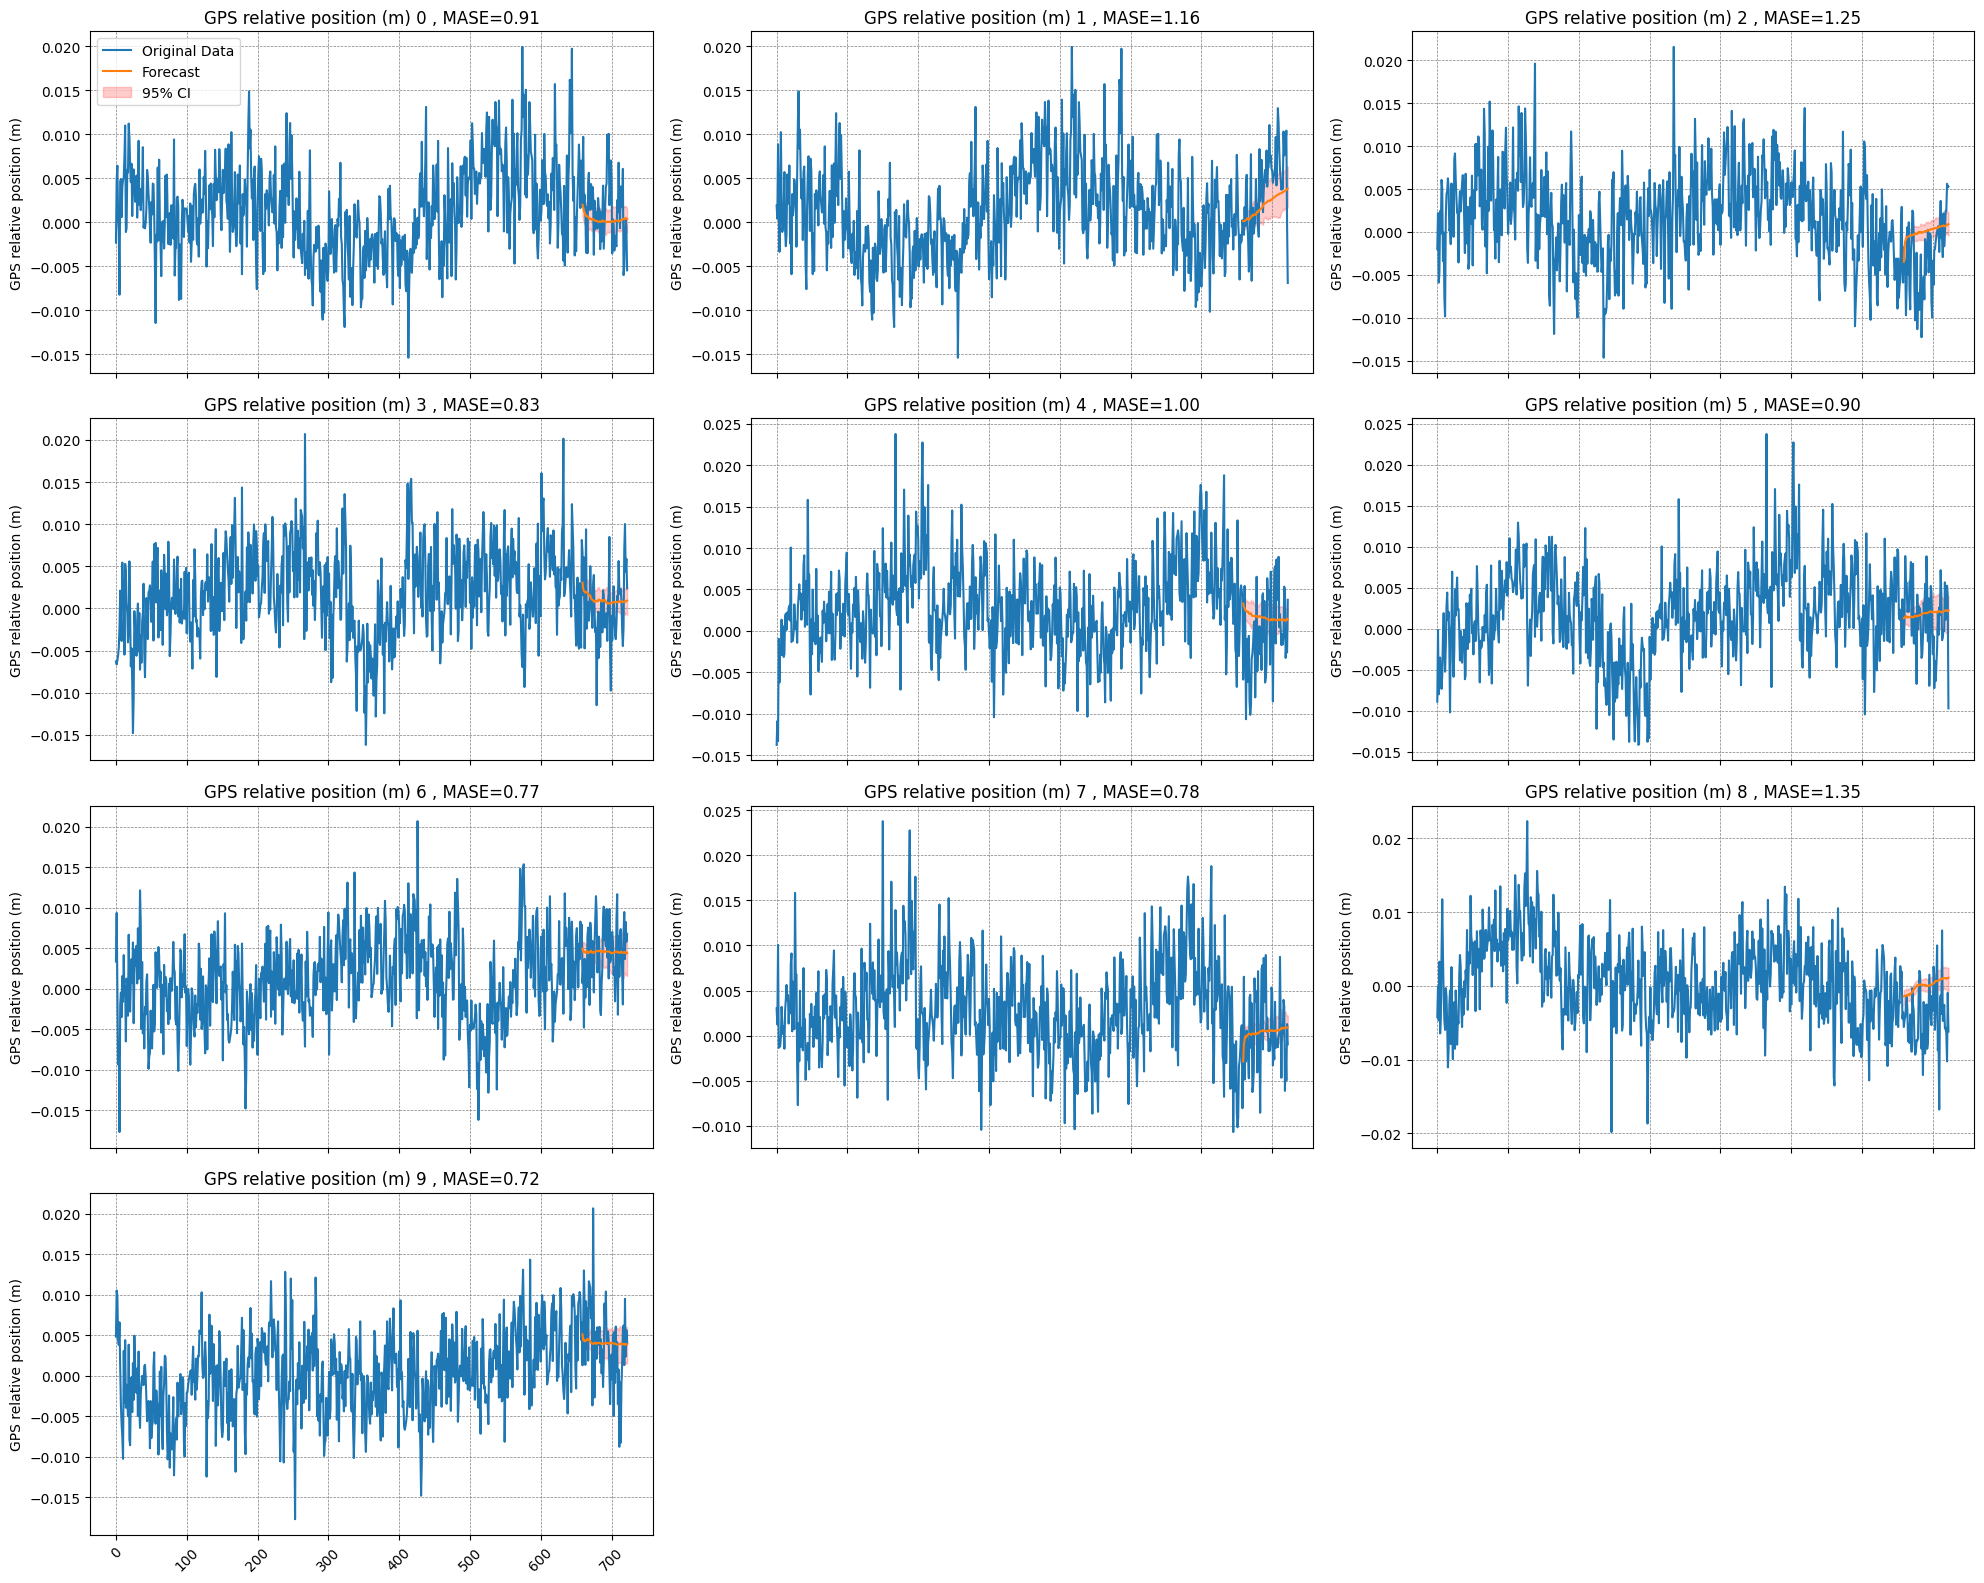

In [211]:
df_list,df_wide = reshape_time_series(df,name_of_target="new delta v (m)", n_timeseries=n_timeseries, duration_years=2)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="GPS relative position (m)",filename="./plots/gps_"+sta_name+"_v_forecast.png")


#### Horizontal components

/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_1499918/35764

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.001615459506091108
Mean Absolute Error (MAE) for target_2: 0.0025631742526002086
Mean Absolute Error (MAE) for target_3: 0.001199059132659366
Mean Absolute Error (MAE) for target_4: 0.004528577389002887
Mean Absolute Error (MAE) for target_5: 0.00295816134519807
Mean Absolute Error (MAE) for target_6: 0.0038742804994739873
Mean Absolute Error (MAE) for target_7: 0.001147325652866
Mean Absolute Error (MAE) for target_8: 0.0018291233962770225
Mean Absolute Error (MAE) for target_9: 0.0015571128749556642
Mean Absolute Error (MAE) for target_10: 0.002399718342722639
Mean of forecast MAEs = 0.0023671992391846946
Mean Absolute Scaled Error (MASE) for target_1: 1.4595432222498756
Mean Absolute Scaled Error (MASE) for target_2: 1.6662880808480387
Mean Absolute Scaled Error (MASE) for target_3: 1.056365897939241
Mean Absolute Scaled Error (MASE) for target_4: 3.4212780370486606
Mean Absolute Scaled Error (MASE) for target_5: 2.04

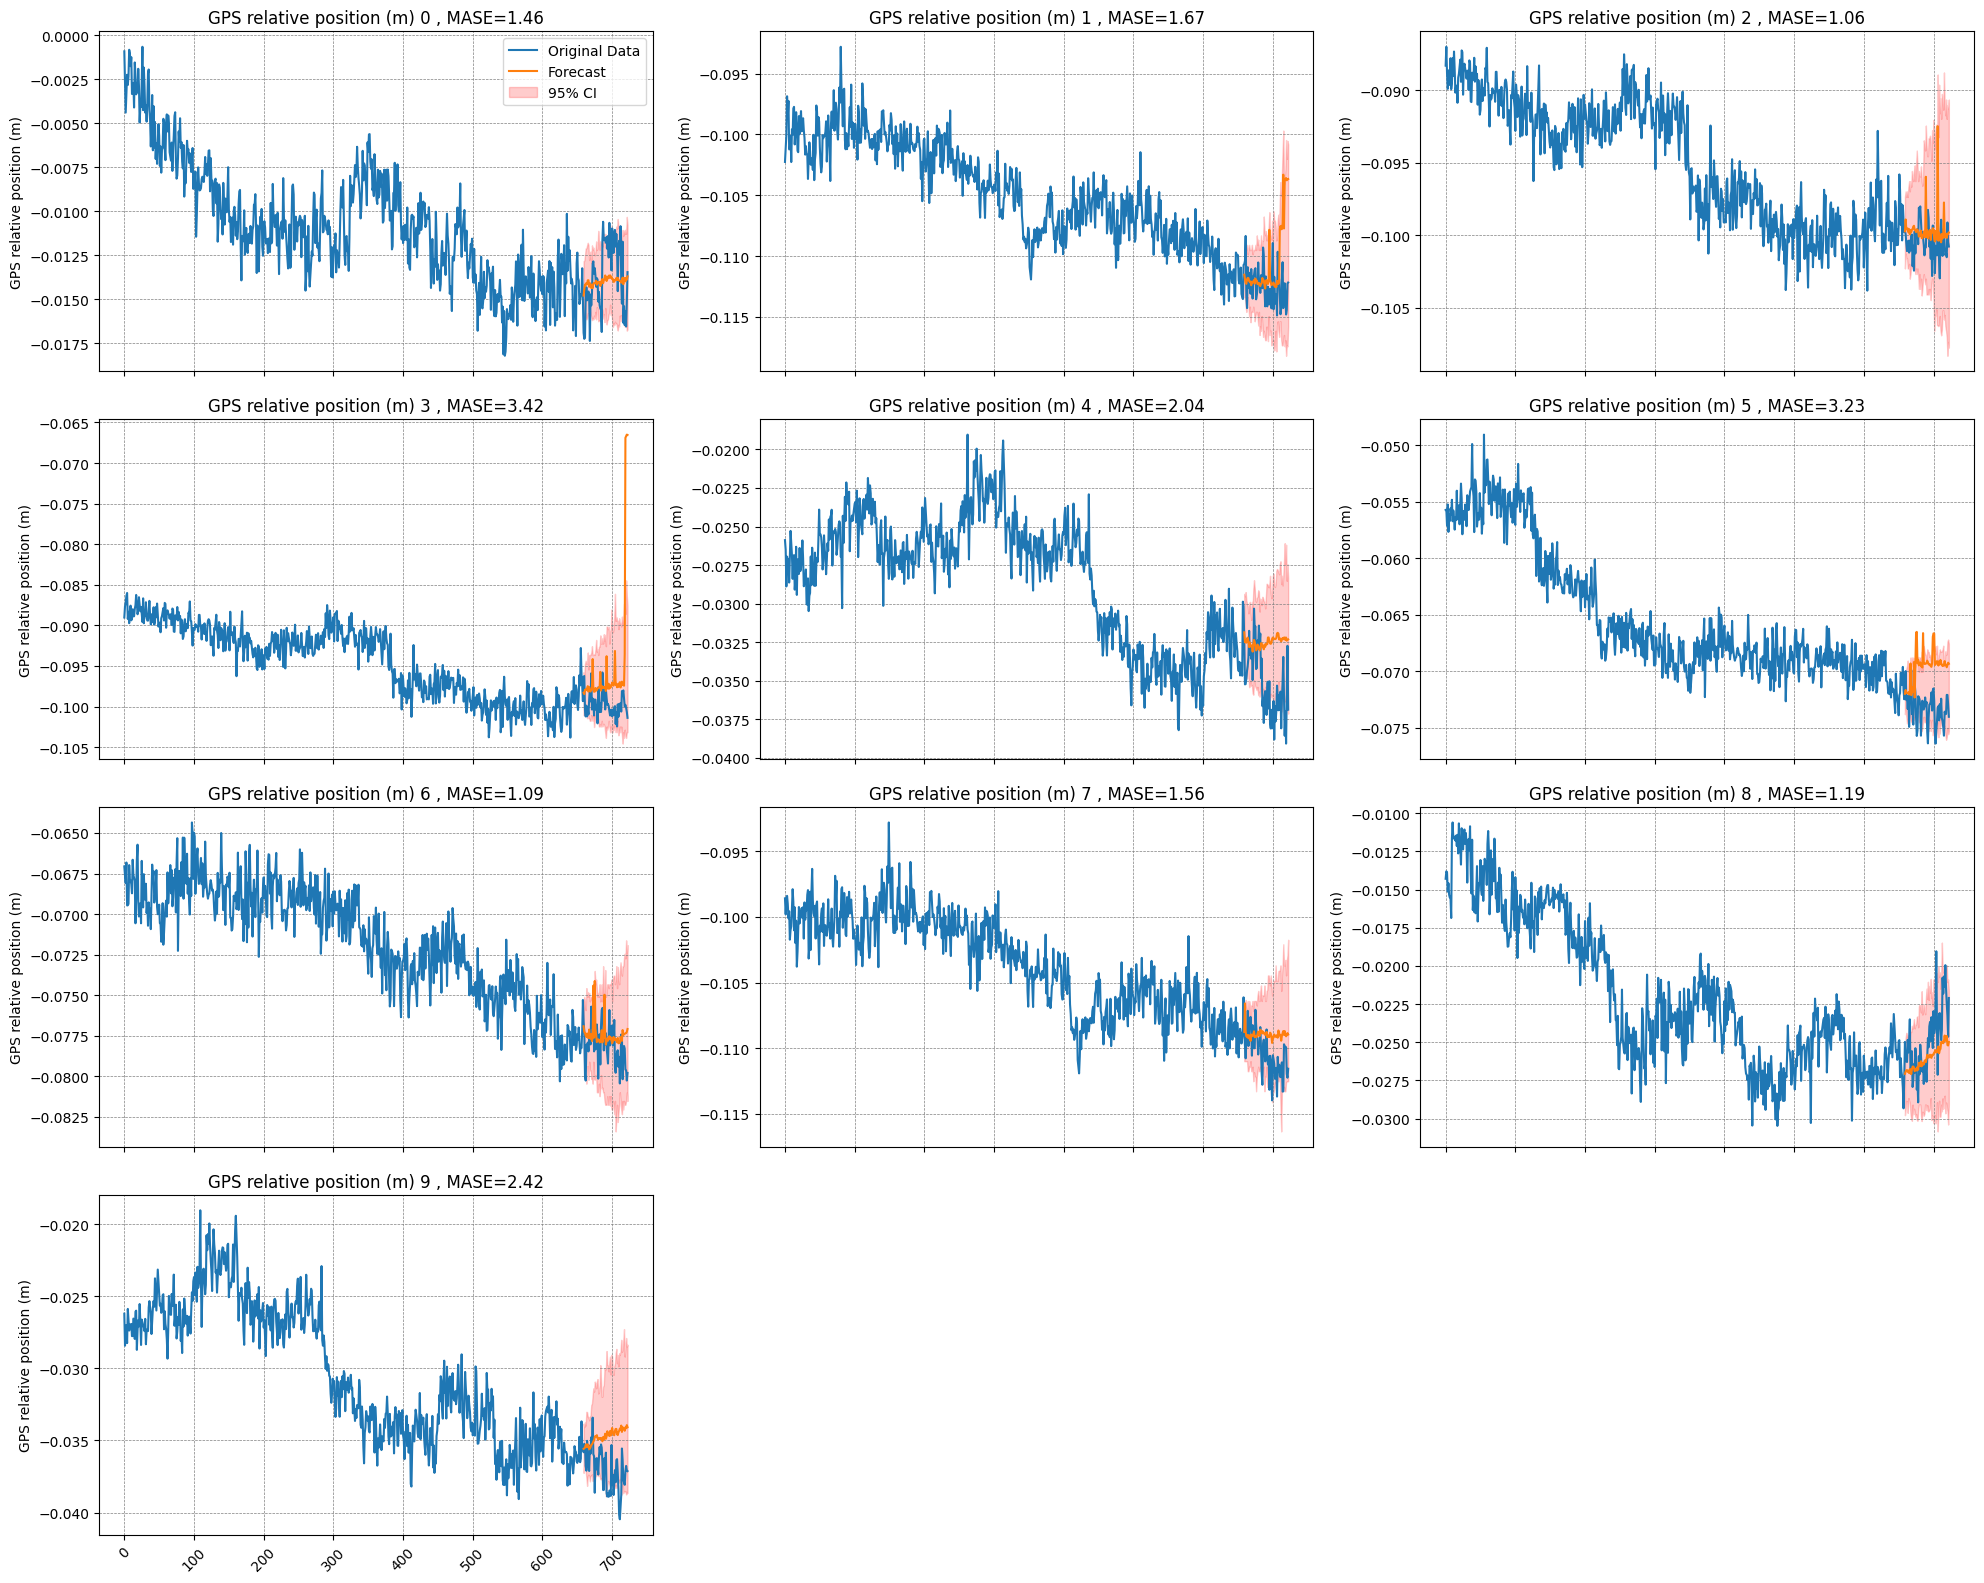

In [212]:
df_list,df_wide = reshape_time_series(df,name_of_target="new delta e (m)", n_timeseries=n_timeseries, duration_years=2)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="GPS relative position (m)",filename="./plots/gps_"+sta_name+"_e_forecast.png")


## 4. Forecast dv/v

In [213]:
# read one dv/v file
fname = "../data/DVV_data_withMean/Data_BGU.csv"
df = pd.read_csv(fname)
df.head()
sta_name = fname.split("/")[-1].split("_")[1]

In [214]:
# convert the date into a timestamp
df["datetime"] = pd.to_datetime(df["date"])
# move datetime to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

## Predict soil moisture

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.009224803212285044
Mean Absolute Error (MAE) for target_2: 0.006057678414136172
Mean Absolute Error (MAE) for target_3: 0.029515433902293442
Mean Absolute Error (MAE) for target_4: 0.00894345328360796
Mean Absolute Error (MAE) for target_5: 0.018847384881973267
Mean Absolute Error (MAE) for target_6: 0.002530024837702513
Mean Absolute Error (MAE) for target_7: 0.025321916654706005
Mean Absolute Error (MAE) for target_8: 0.0032958161808550384
Mean Absolute Error (MAE) for target_9: 0.002556499534845349
Mean Absolute Error (MAE) for target_10: 0.029787788499891756
Mean of forecast MAEs = 0.013608079940229653
Mean Absolute Scaled Error (MASE) for target_1: 17.29650602303448
Mean Absolute Scaled Error (MASE) for target_2: 20.740964135357576
Mean Absolute Scaled Error (MASE) for target_3: 37.11521628432099
Mean Absolute Scaled Error (MASE) for target_4: 26.452467458558775
Mean Absolute Scaled Error (MASE) for target_5: 17.035

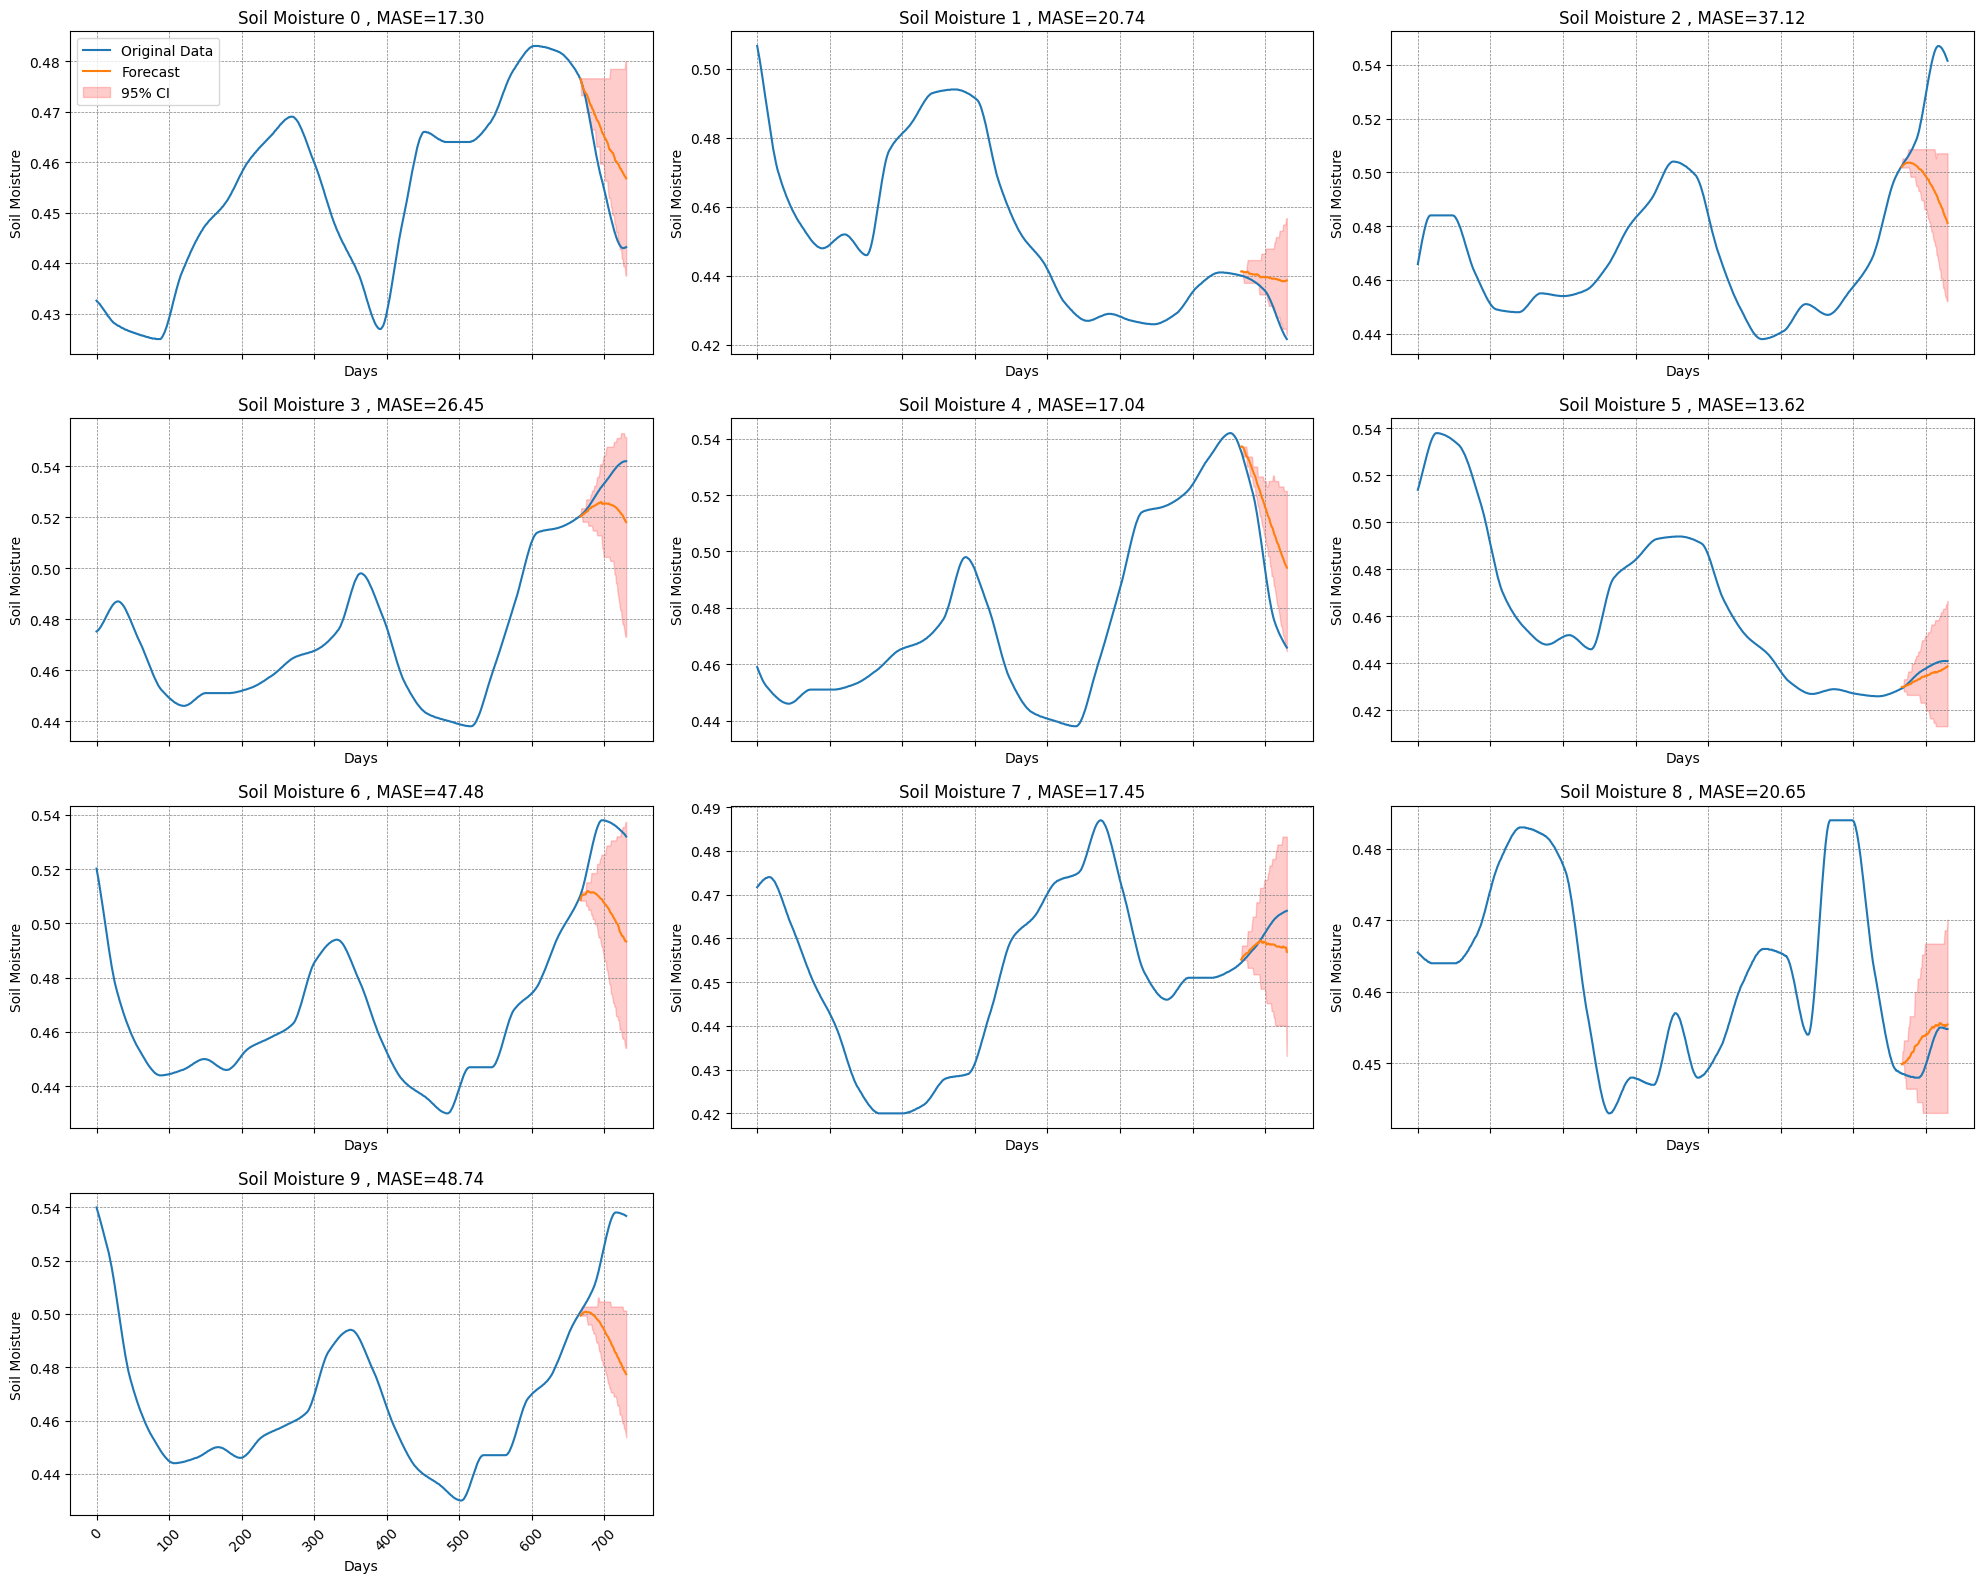

In [217]:
df_list,df_wide = reshape_time_series(df,name_of_target="sm_ewt", n_timeseries=n_timeseries, duration_years=2)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="Soil Moisture",filename="./plots/"+sta_name+"_SM_forecast.png")


In [220]:
df.keys()

Index(['datetime', 'date', 'dv', 'temp', 'sm_ewt', 'lp_lake', 'lake'], dtype='object')

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.03303085723603144
Mean Absolute Error (MAE) for target_2: 0.03072059813225642
Mean Absolute Error (MAE) for target_3: 0.06821781722712913
Mean Absolute Error (MAE) for target_4: 0.16704487981339916
Mean Absolute Error (MAE) for target_5: 0.01908331306055188
Mean Absolute Error (MAE) for target_6: 0.024370457958616316
Mean Absolute Error (MAE) for target_7: 0.025505704370141033
Mean Absolute Error (MAE) for target_8: 0.012605565744917838
Mean Absolute Error (MAE) for target_9: 0.07018318823426963
Mean Absolute Error (MAE) for target_10: 0.01445774738311884
Mean of forecast MAEs = 0.046522012916043166
Mean Absolute Scaled Error (MASE) for target_1: 22.993856418452822
Mean Absolute Scaled Error (MASE) for target_2: 12.8854705880969
Mean Absolute Scaled Error (MASE) for target_3: 15.398504067750402
Mean Absolute Scaled Error (MASE) for target_4: 22.5397888803687
Mean Absolute Scaled Error (MASE) for target_5: 7.1350072570609

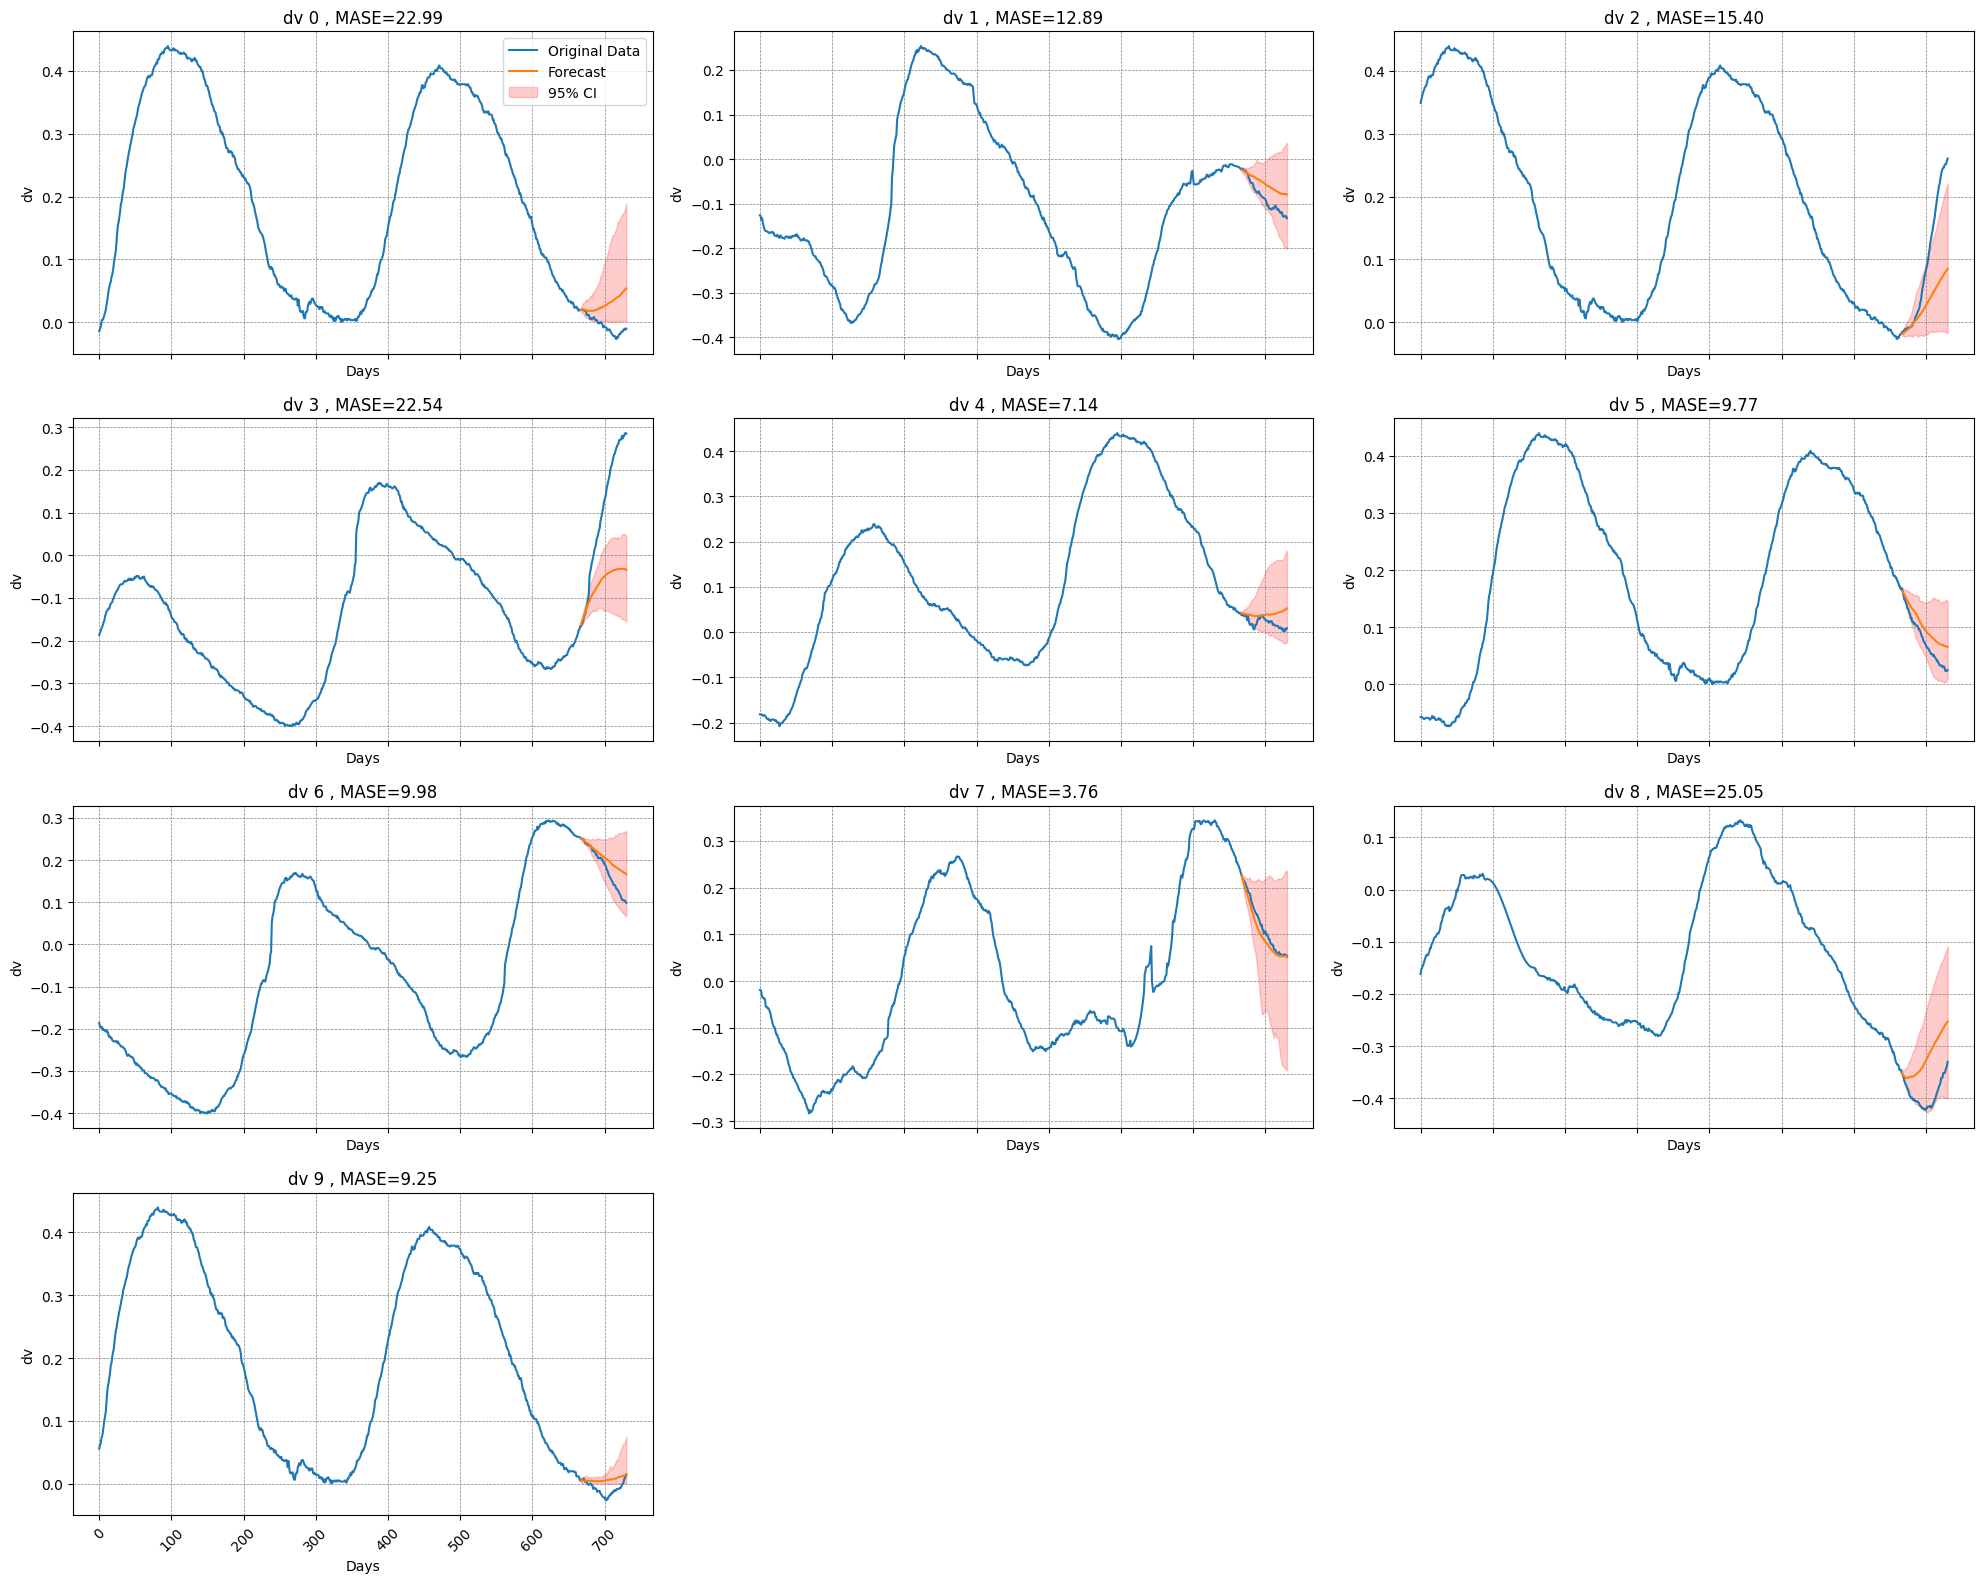

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 1.1936487503454087
Mean Absolute Error (MAE) for target_2: 0.9857682670354844
Mean Absolute Error (MAE) for target_3: 2.589625034370646
Mean Absolute Error (MAE) for target_4: 1.239445412015915
Mean Absolute Error (MAE) for target_5: 2.0505392247885466
Mean Absolute Error (MAE) for target_6: 1.499825231806637
Mean Absolute Error (MAE) for target_7: 0.7878545136395843
Mean Absolute Error (MAE) for target_8: 0.45963113217353807
Mean Absolute Error (MAE) for target_9: 0.6108502878844739
Mean Absolute Error (MAE) for target_10: 4.330088576447964
Mean of forecast MAEs = 1.5747276430508197
Mean Absolute Scaled Error (MASE) for target_1: 11.233082571030062
Mean Absolute Scaled Error (MASE) for target_2: 5.521823864641416
Mean Absolute Scaled Error (MASE) for target_3: 22.310615680731715
Mean Absolute Scaled Error (MASE) for target_4: 12.342927296682545
Mean Absolute Scaled Error (MASE) for target_5: 12.189466990156486
Mean Absolu

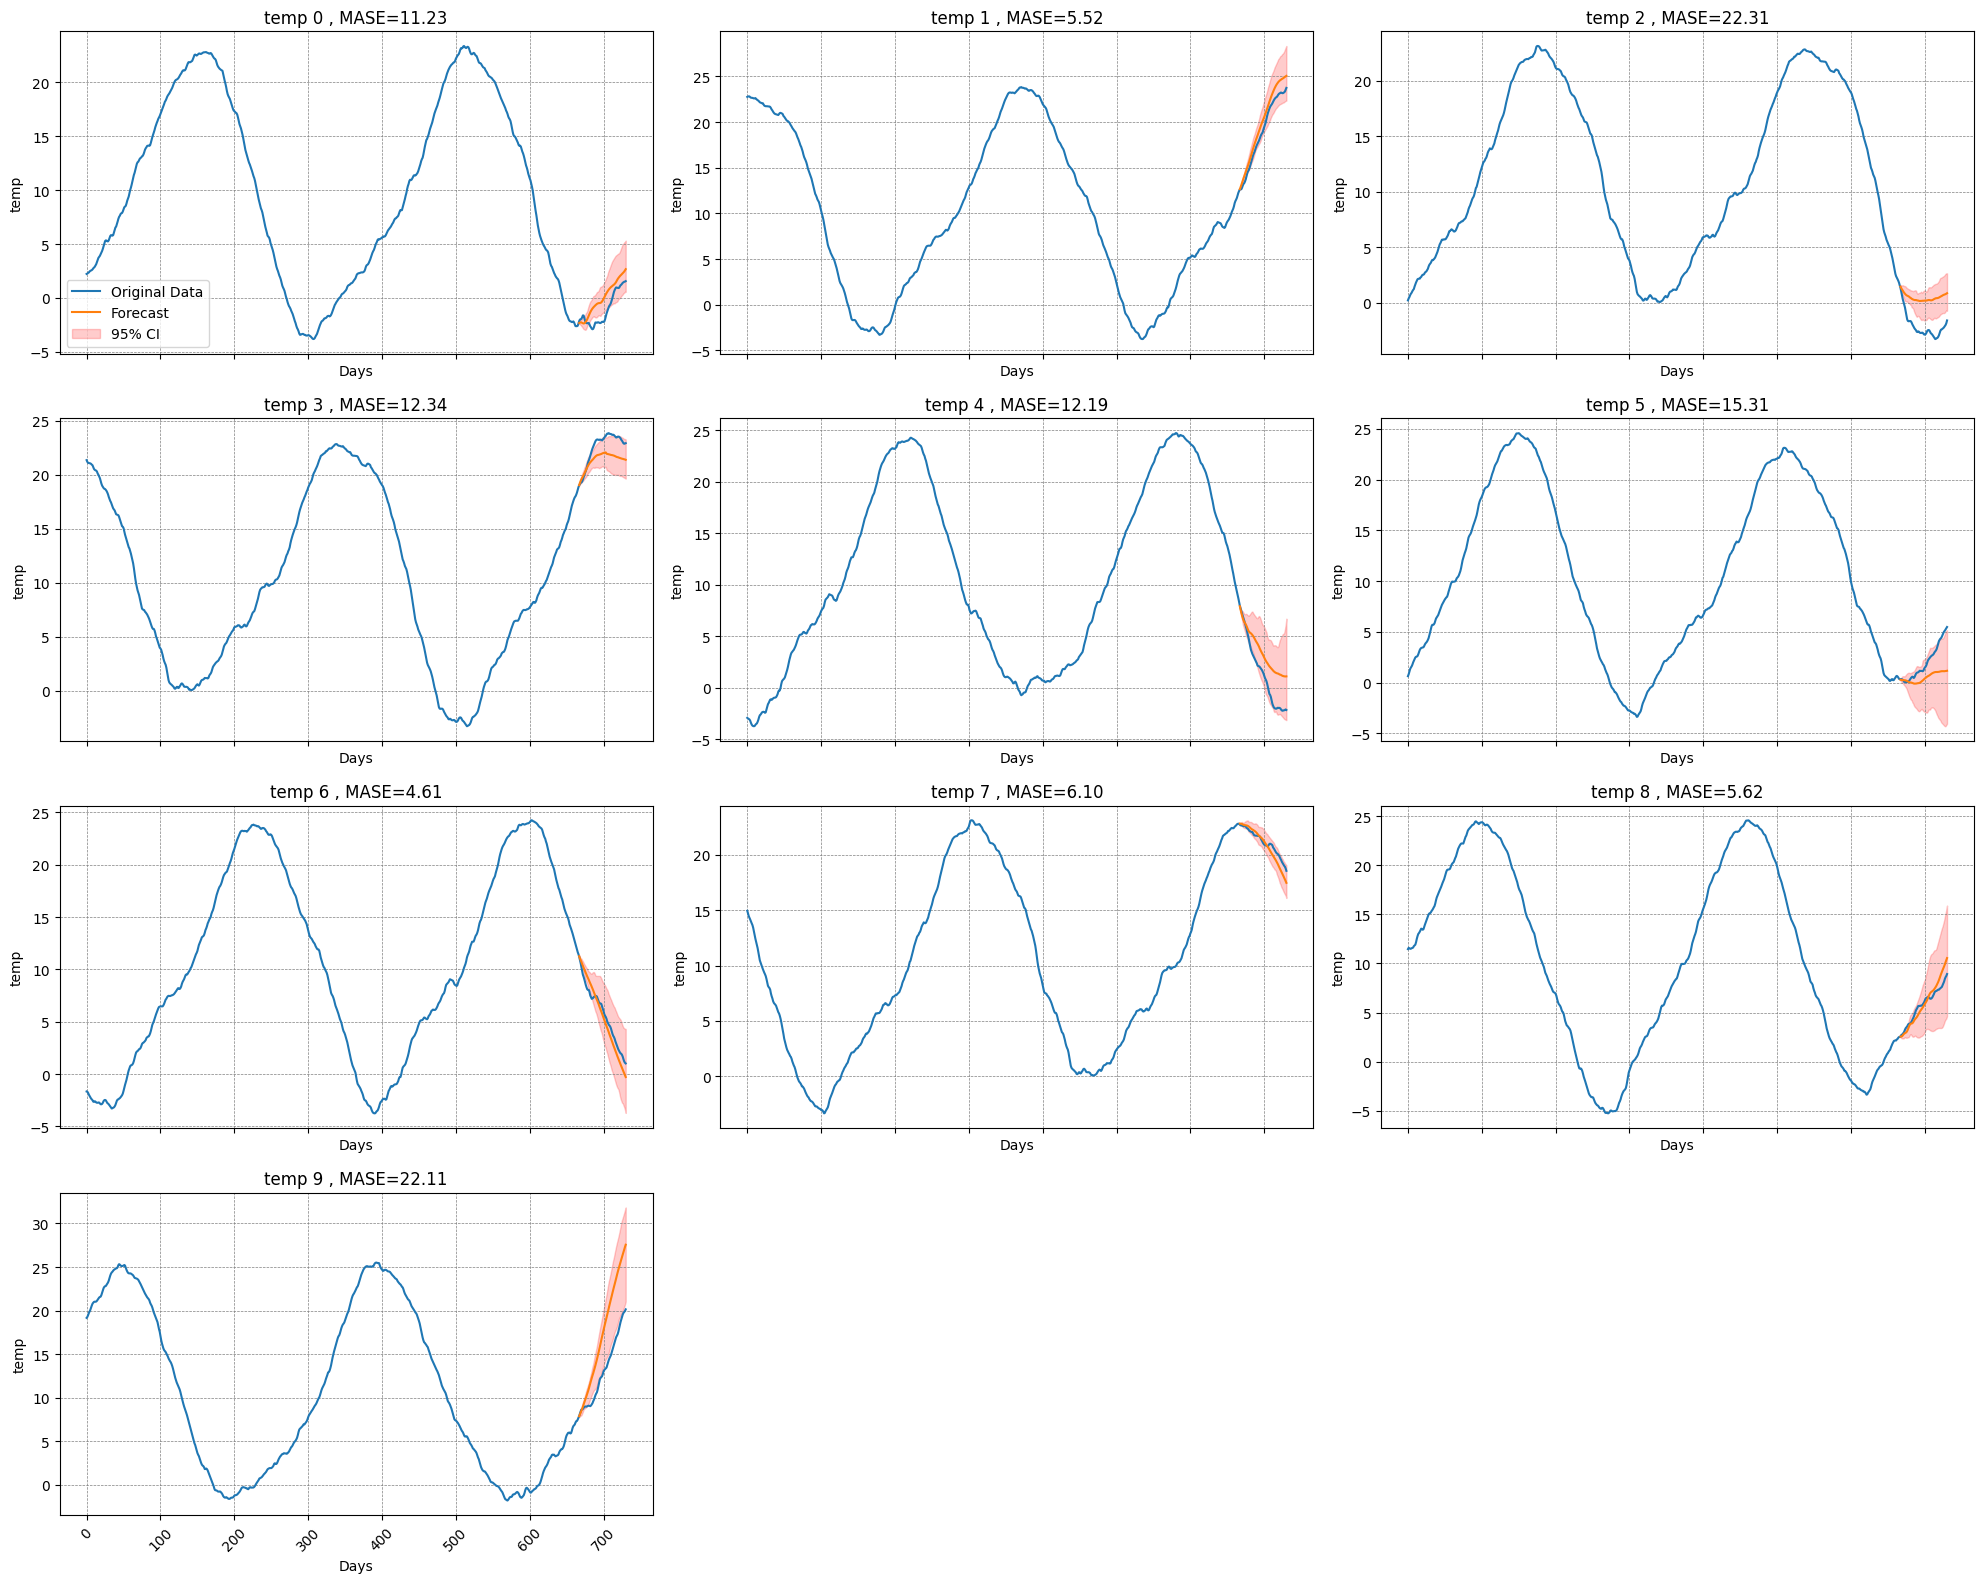

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.0022276716329157342
Mean Absolute Error (MAE) for target_2: 0.007746200501918792
Mean Absolute Error (MAE) for target_3: 0.015038203714787961
Mean Absolute Error (MAE) for target_4: 0.02673765170946717
Mean Absolute Error (MAE) for target_5: 0.008700411557406189
Mean Absolute Error (MAE) for target_6: 0.003691971152275802
Mean Absolute Error (MAE) for target_7: 0.002582851938903335
Mean Absolute Error (MAE) for target_8: 0.0008753810793161411
Mean Absolute Error (MAE) for target_9: 0.006432570342719554
Mean Absolute Error (MAE) for target_10: 0.005088757170736791
Mean of forecast MAEs = 0.007912167080044748
Mean Absolute Scaled Error (MASE) for target_1: 6.527595947613541
Mean Absolute Scaled Error (MASE) for target_2: 17.063308797932994
Mean Absolute Scaled Error (MASE) for target_3: 25.196990266799002
Mean Absolute Scaled Error (MASE) for target_4: 40.4921167715487
Mean Absolute Scaled Error (MASE) for target_5: 45.299

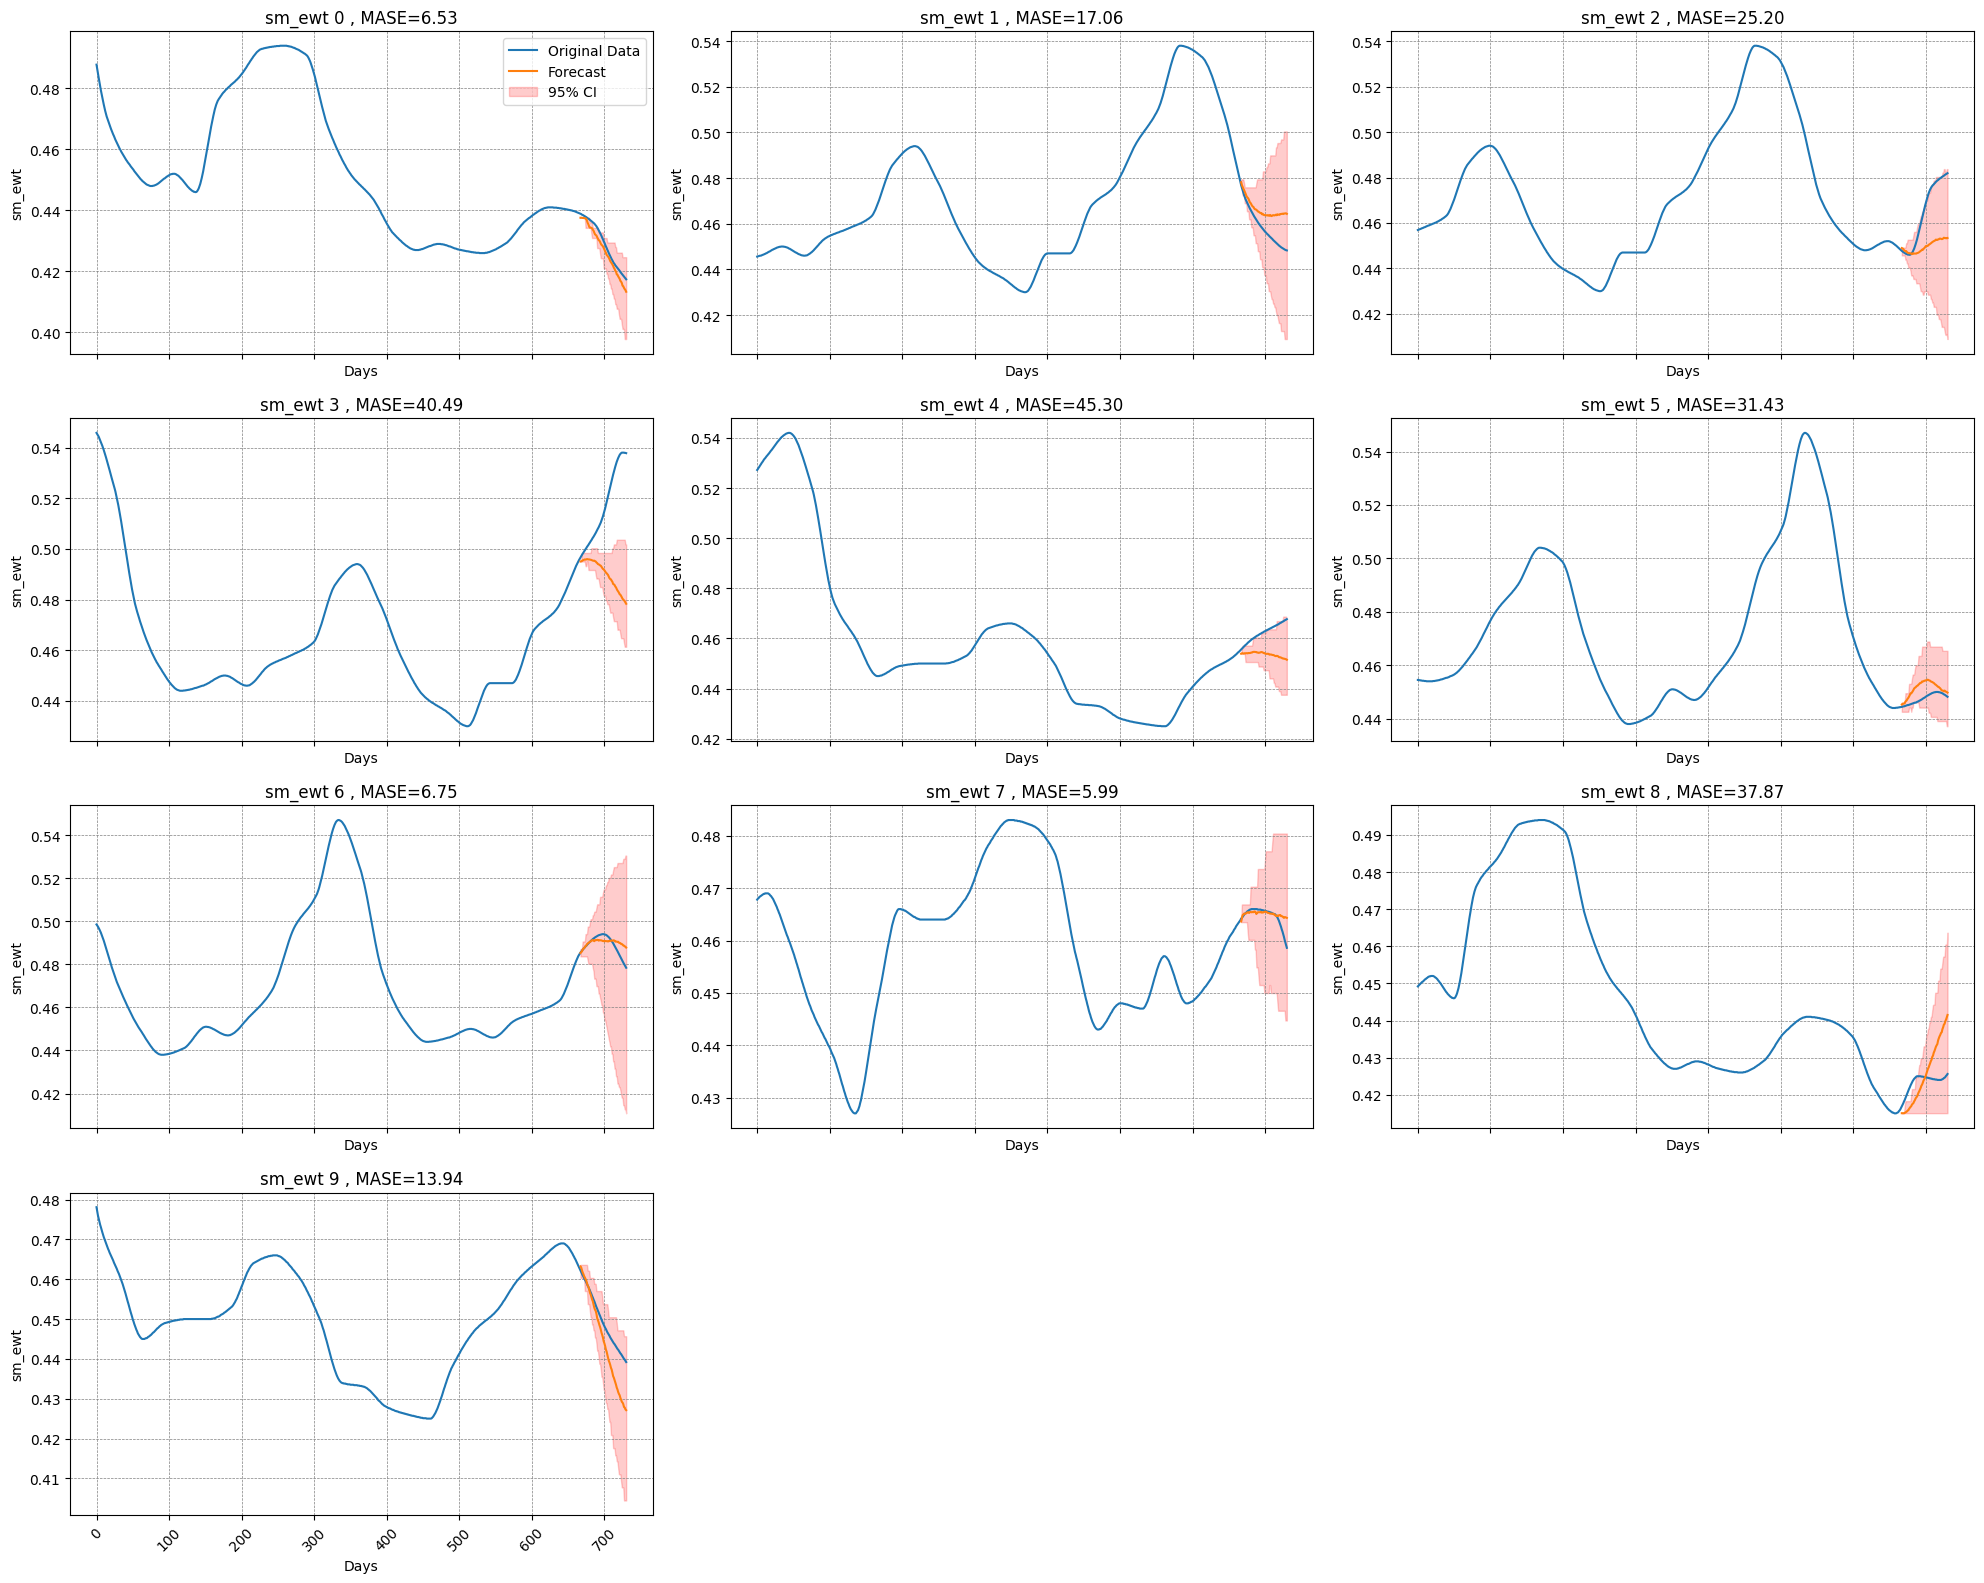

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.010433960369229316
Mean Absolute Error (MAE) for target_2: 0.0022704888865351606
Mean Absolute Error (MAE) for target_3: 0.0009781417503952972
Mean Absolute Error (MAE) for target_4: 0.02271545969898507
Mean Absolute Error (MAE) for target_5: 0.007833118988573551
Mean Absolute Error (MAE) for target_6: 0.005904288672655821
Mean Absolute Error (MAE) for target_7: 0.004120417890697722
Mean Absolute Error (MAE) for target_8: 0.012287129511591046
Mean Absolute Error (MAE) for target_9: 0.0016696501446887852
Mean Absolute Error (MAE) for target_10: 0.01895172315053642
Mean of forecast MAEs = 0.008716437906388819
Mean Absolute Scaled Error (MASE) for target_1: 9.14241311907437
Mean Absolute Scaled Error (MASE) for target_2: 1.1734273982913461
Mean Absolute Scaled Error (MASE) for target_3: 1.4957021911384394
Mean Absolute Scaled Error (MASE) for target_4: 7.677435413283581
Mean Absolute Scaled Error (MASE) for target_5: 24.430

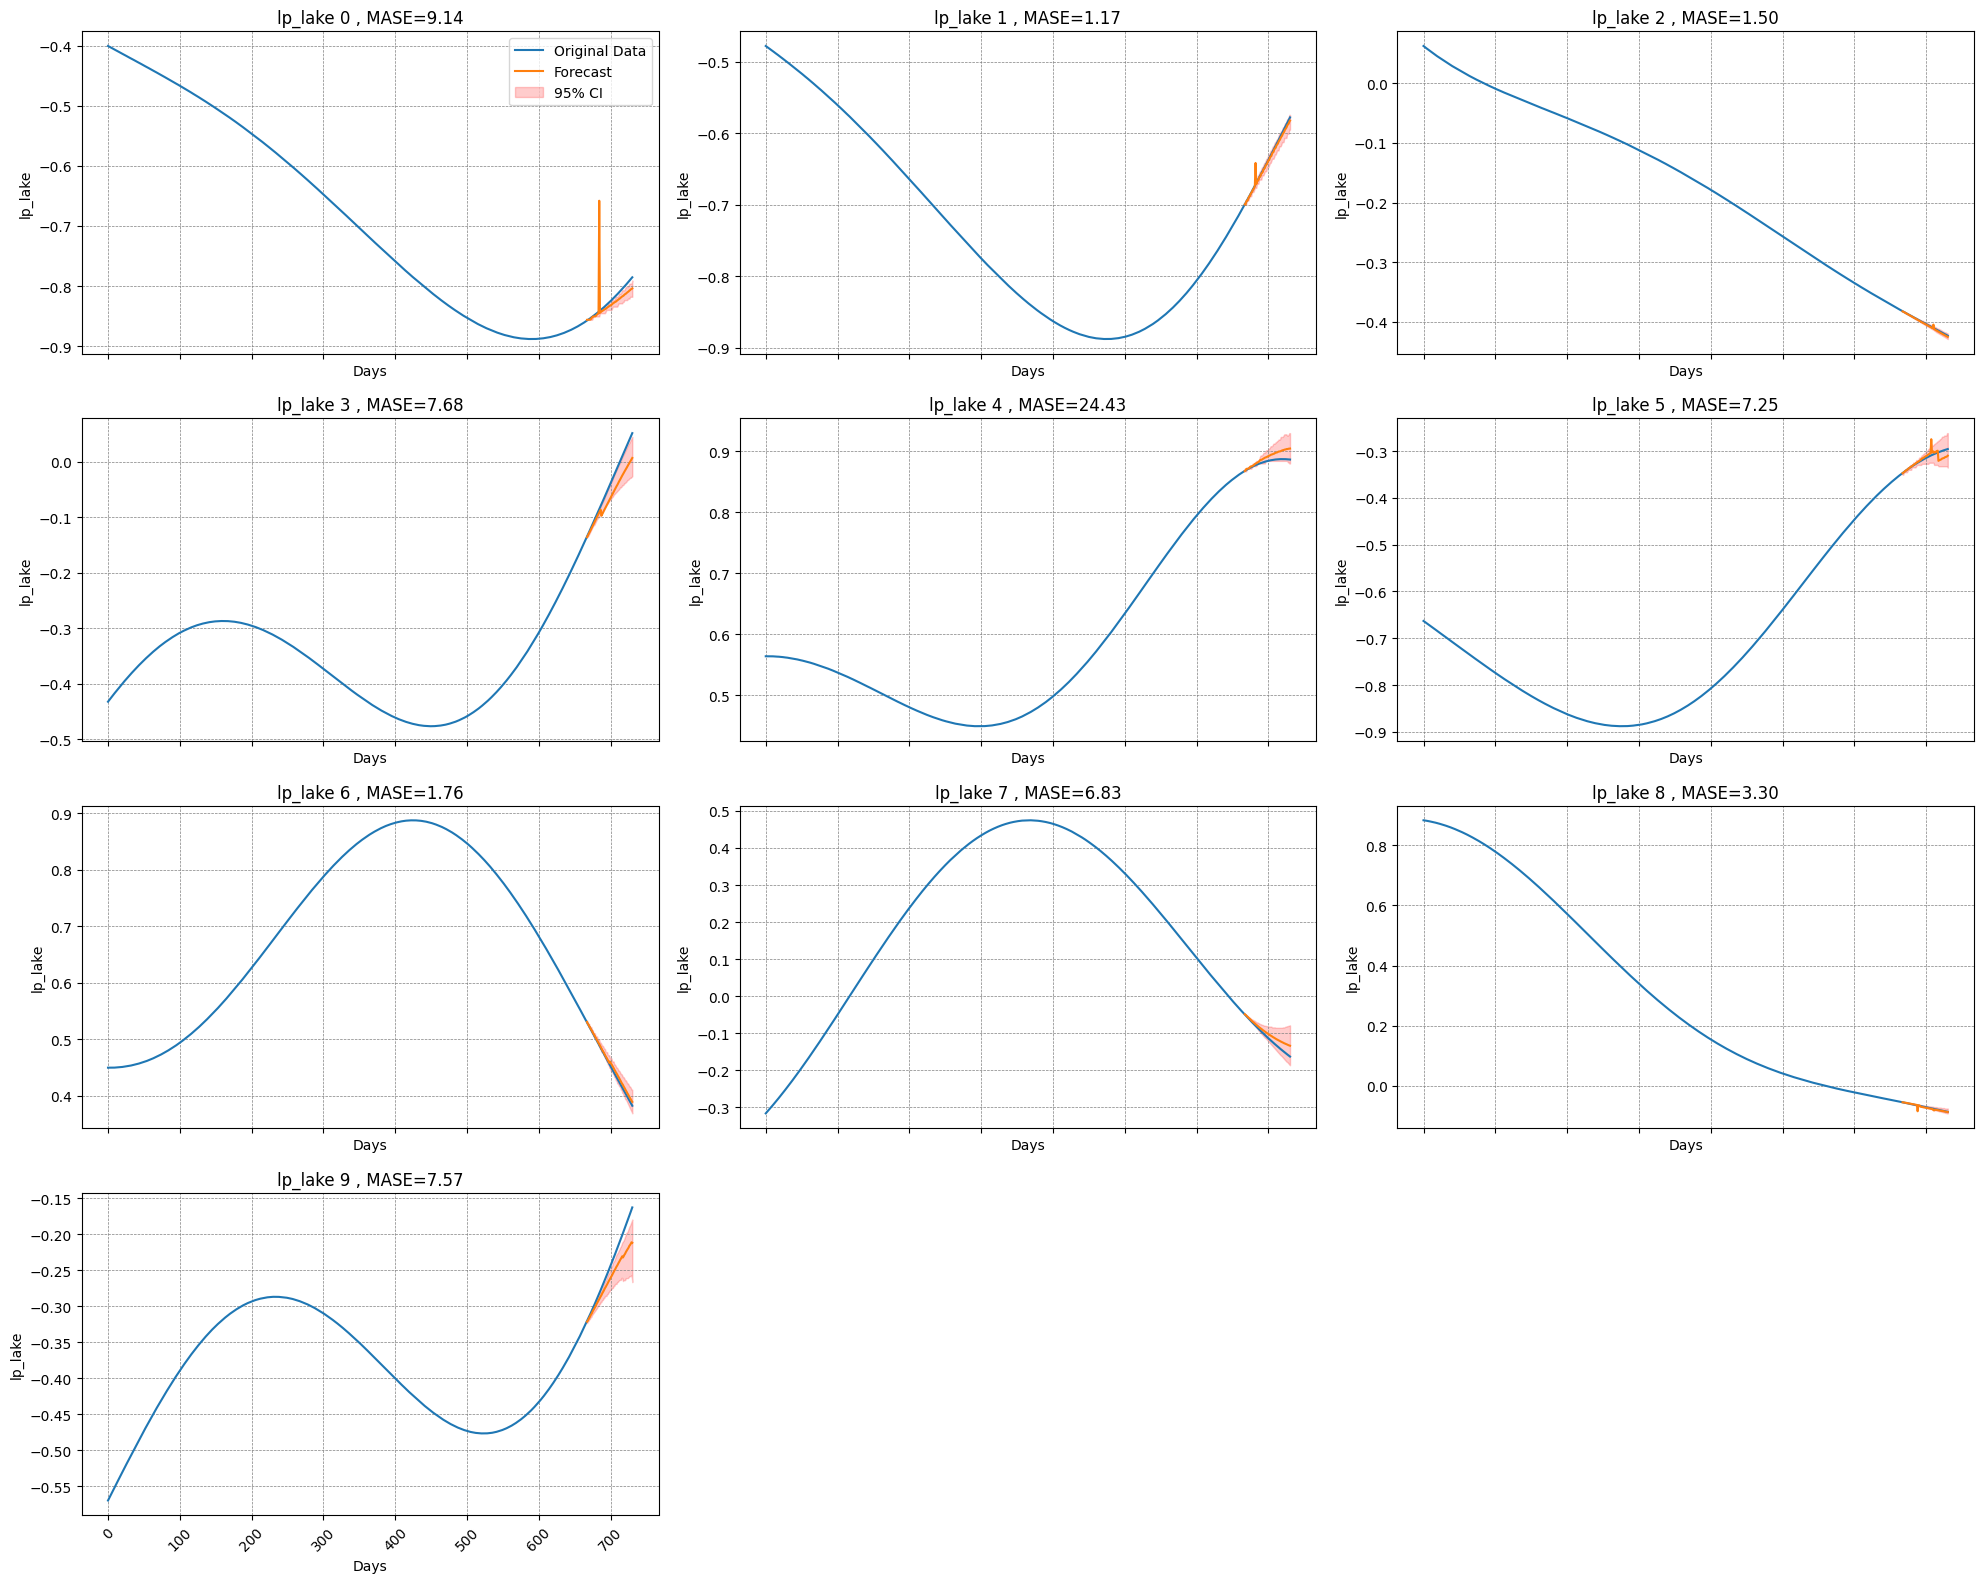

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 10.71772432250977
Mean Absolute Error (MAE) for target_2: 11.39613328857422
Mean Absolute Error (MAE) for target_3: 68.22461653442383
Mean Absolute Error (MAE) for target_4: 4.0319347656249995
Mean Absolute Error (MAE) for target_5: 4.468378710937497
Mean Absolute Error (MAE) for target_6: 4.263623828125009
Mean Absolute Error (MAE) for target_7: 1.8257643066406217
Mean Absolute Error (MAE) for target_8: 4.203290234375
Mean Absolute Error (MAE) for target_9: 3.560475390625001
Mean Absolute Error (MAE) for target_10: 3.9573910156249923
Mean of forecast MAEs = 11.664933239746095
Mean Absolute Scaled Error (MASE) for target_1: 2829.9104455898523
Mean Absolute Scaled Error (MASE) for target_2: 2156.025216756743
Mean Absolute Scaled Error (MASE) for target_3: 37703.07755856175
Mean Absolute Scaled Error (MASE) for target_4: 1783.791364003191
Mean Absolute Scaled Error (MASE) for target_5: 1712.3349074748583
Mean Absolute Scaled

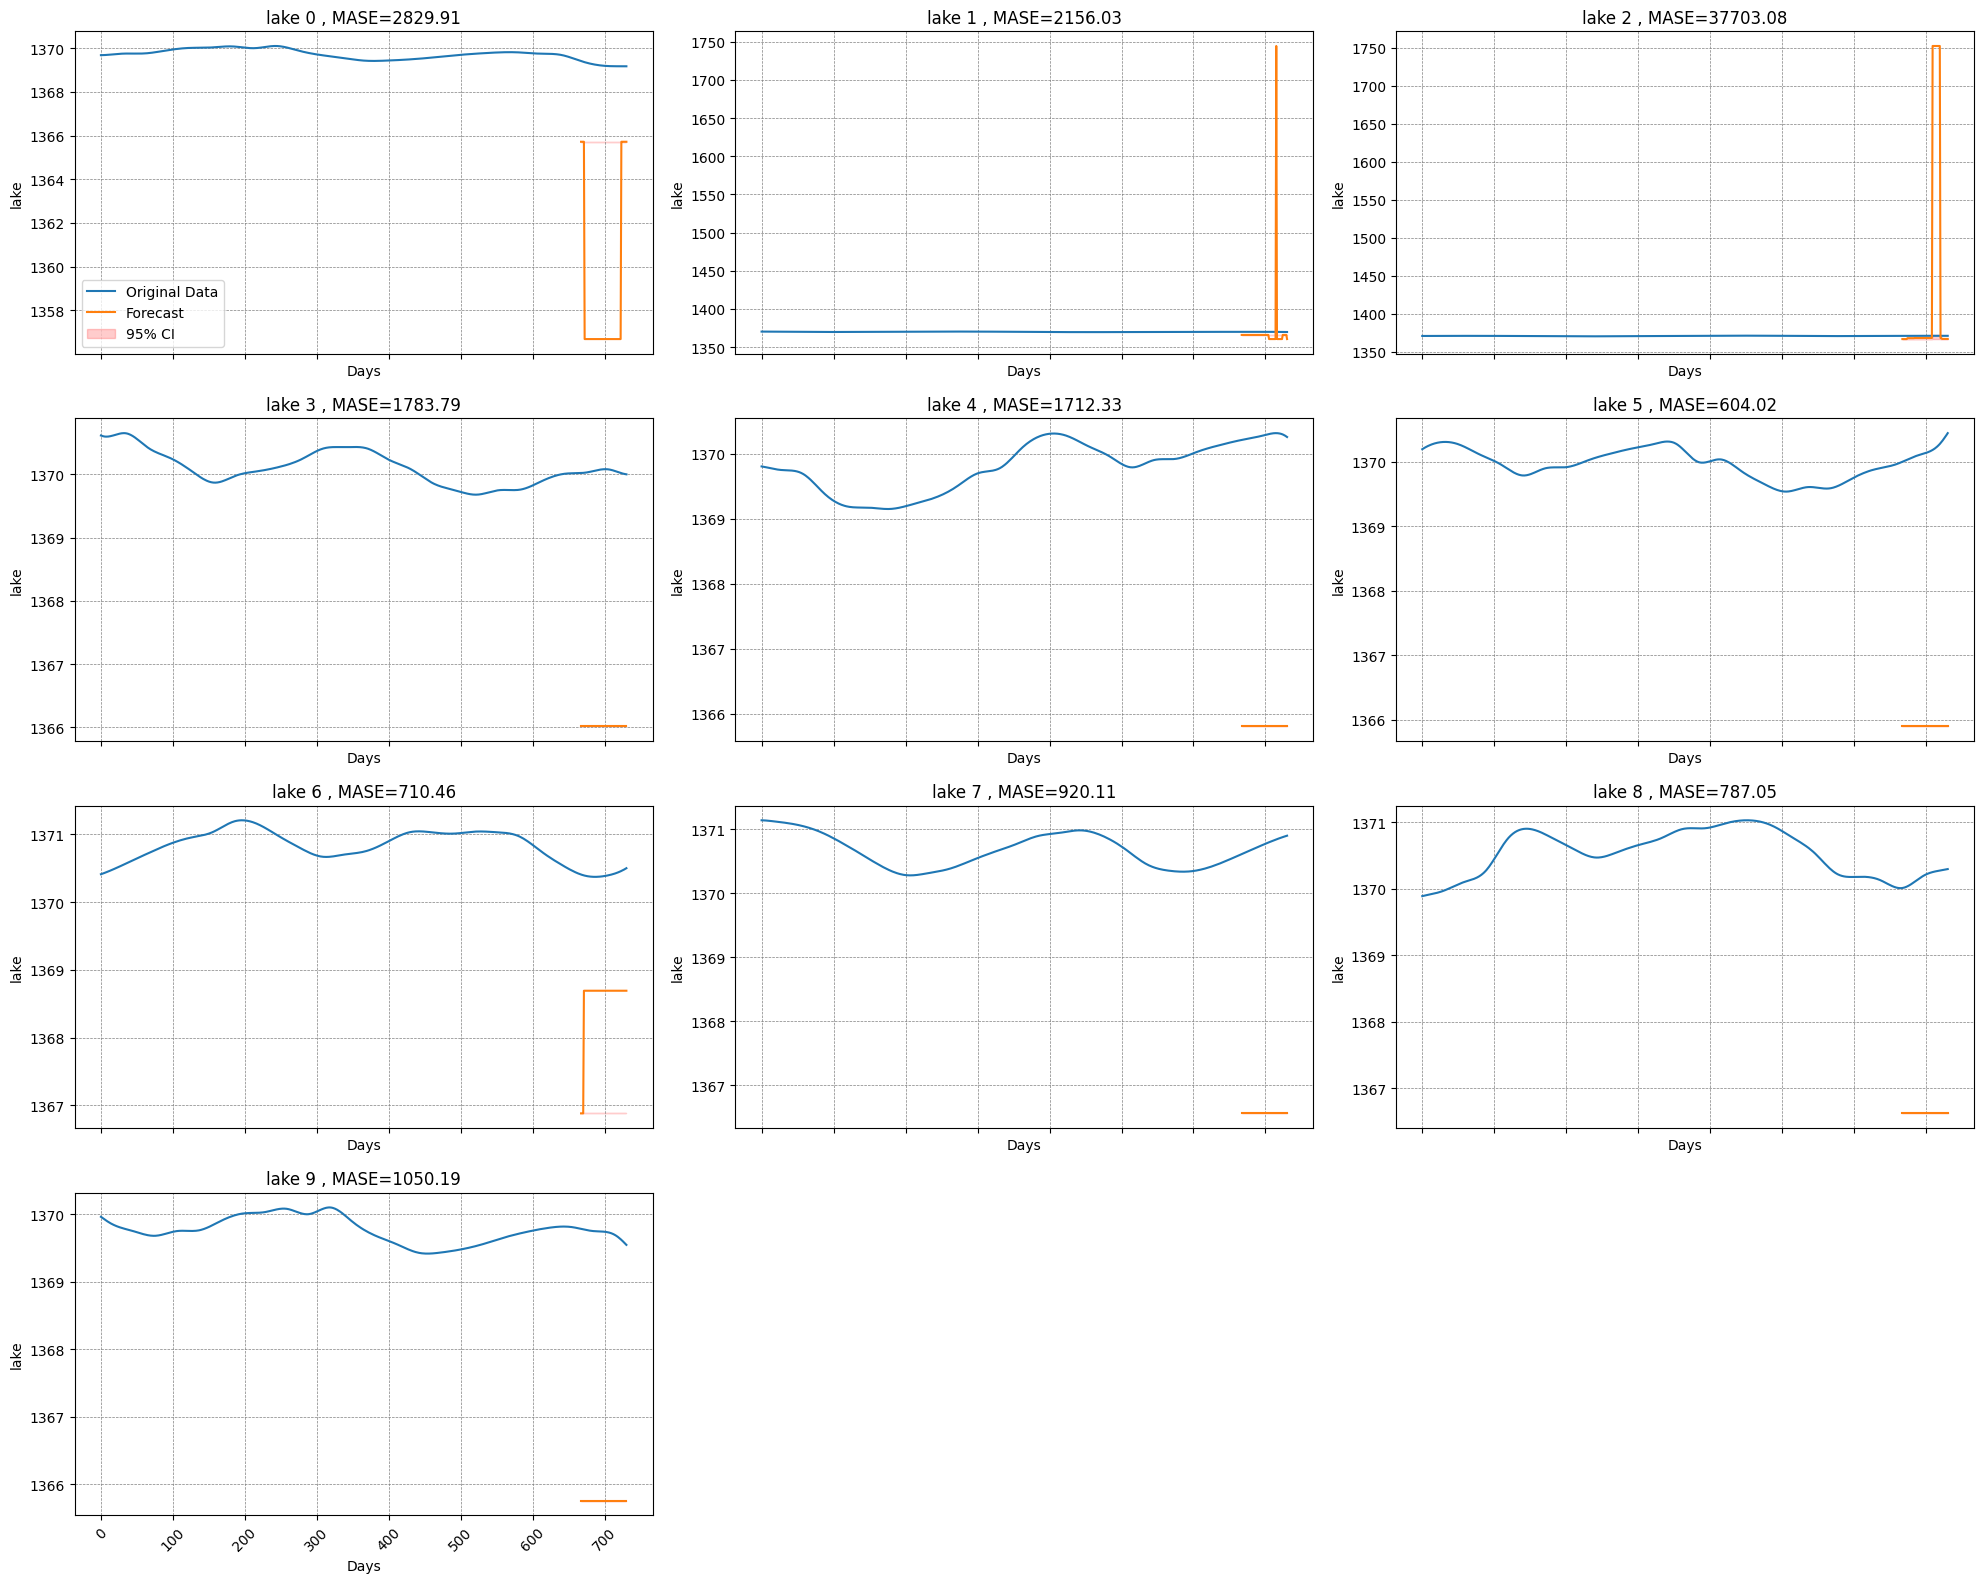

In [222]:
for ikey in df.keys()[2:]:
    df_list,df_wide = reshape_time_series(df,name_of_target=ikey, n_timeseries=n_timeseries, duration_years=2)
    # now predict with chronos
    forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
    # plot the forecast
    plot_forecasts(df_wide,split_index,forecast,n_timeseries,field=ikey,filename="./plots/"+sta_name+"_"+ikey+"_forecast.png")

## Wave data

In [238]:
# read CSV file with waveforms in them
df = pd.read_csv("../data/data_waveforms.csv")
df.head()

time             Z             N             E
0   0.0  20525.021459 -19224.056196 -47203.488344
1   0.2  -7242.363758   4543.589720  14463.495052
2   0.4  -1562.630597   5935.755557  -9257.204055
3   0.6   -907.924879  -4912.978439   3321.988412
4   0.8   -432.534303   1306.775470  -9014.431029

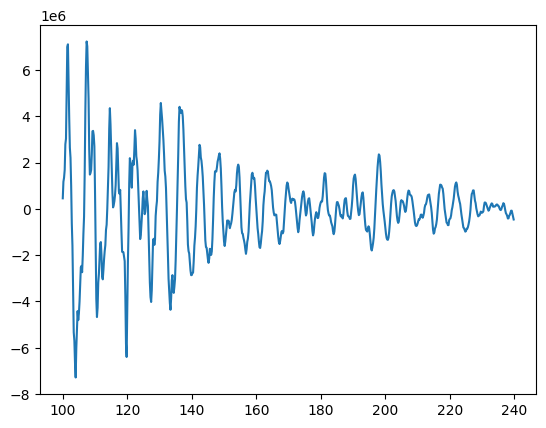

In [240]:


# trim data between 100 and 200 rows
df = df.iloc[300:1000]
plt.plot(df['time'],df['Z'])

In [242]:
#make a datetime column
df["datetime"] = pd.to_datetime(df["time"], unit='s')

In [243]:

for ikey in df.keys()[1:-1]:
    df_list,df_wide = reshape_time_series(df,name_of_target=ikey, n_timeseries=n_timeseries, duration_years=2)
    # now predict with chronos
    forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
    # plot the forecast
    plot_forecasts(df_wide,split_index,forecast,n_timeseries,field=ikey,filename="./plots/waveform_"+ikey+"_forecast.png")

/tmp/ipykernel_1499918/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)


KeyboardInterrupt: 